In [1]:
#imports
import os
from os import listdir
from os.path import isfile, join
from pydub import AudioSegment, silence
from pydub.silence import split_on_silence
from pydub.playback import play
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import datetime
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D , MaxPool1D , Flatten , Dropout, Activation, BatchNormalization, MaxPooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.optimizers import SGD, RMSprop
from keras.optimizers import schedules
import time

import warnings
warnings.filterwarnings("ignore")

# pd.set_option('expand_frame_repr', False)
# pd.set_option('display.max_columns', None)
pd.reset_option('max_columns')

Using TensorFlow backend.


#### Reading and Processing Audio File

In [2]:
current_directory = os.getcwd()
print(current_directory)

/home/akshayrauthan0806/Research - PD


In [3]:
def create_Folder_Str(parentDir):
    
    # get the current working directory
    current_directory = os.getcwd()
    print(current_directory)

    # chunks directory
    parent_directory = current_directory + "/" + parentDir
    parent_read_directory = parent_directory + "/" + "Read Text"
    parent_read_hc_directory = parent_read_directory + "/" + "HC"
    parent_read_pd_directory = parent_read_directory + "/" + "PD"
    parent_sp_directory = parent_directory + "/" + "Spontaneous"
    parent_sp_hc_directory = parent_sp_directory + "/" + "HC"
    parent_sp_pd_directory = parent_sp_directory + "/" + "PD"


    # creating forlder for chunks.
    MYDIR = (parentDir)
    CHECK_FOLDER = os.path.isdir(MYDIR)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        #os.makedirs(MYDIR)
        os.makedirs(os.path.join(parentDir, 'Read Text', 'HC'))
        os.chdir(parent_read_directory)
        os.makedirs('PD')
        os.chdir(parent_directory)
        os.makedirs(os.path.join('Spontaneous', 'HC'))
        os.chdir(parent_sp_directory)
        os.makedirs('PD')
        os.chdir(current_directory)
        print("Folders Created")
    else:
        print(MYDIR, "folder already exists.")

In [4]:
# call to create folders for initial filtered chunks & noise reduced audios 
create_Folder_Str('Chunks')
create_Folder_Str('ProcessedAudio')

/home/akshayrauthan0806/Research - PD
Chunks folder already exists.
/home/akshayrauthan0806/Research - PD
ProcessedAudio folder already exists.


In [5]:
def sound_properties(sound):
    
    #loudness
    loudness = sound.dBFS
    
    #number of frames in sound
    number_of_frames_in_sound = sound.frame_count()
    
    #number of frames in .5 secs
    number_of_frames_in_200ms_of_sound = sound.frame_count(ms=500)
    
    #nummber of frames in 1 milliseconds    
    number_of_frames_in_1ms_of_sound = sound.frame_count(ms=1)
    
    #frame rate
    frame_rate = sound.frame_rate
    
    #number of channels
    num_of_channels = sound.channels
    
    #number of bytes per sample
    sample_width = sound.sample_width
    
    #max amplitude
    max_amplitude = sound.max
    
#     print(loudness, number_of_frames_in_sound, number_of_frames_in_200ms_of_sound, number_of_frames_in_1ms_of_sound)
    print("Loudness - ", loudness )
    print("Frame Count - ", number_of_frames_in_sound)
    print("Frame Rate - ", frame_rate)
    print("Channels - ", num_of_channels)
    print("Sample Width - ", sample_width)
    print("Max Amplitude - ", max_amplitude)

In [60]:
# read a sample audio file and print basic properties
# sound = AudioSegment.from_wav("./ProcessedAudio/Read Text/PD/ID02_pd_2_0_0.wav")
# sound_properties(sound)

Loudness -  -34.69384996746698
Frame Count -  5099326.0
Frame Rate -  44100
Channels -  1
Sample Width -  4
Max Amplitude -  539295489


In [61]:
# def loadAudio(soundPath):
#     x, sr = librosa.load(soundPath)
#     return x, sr

In [65]:
# def disaplayWavePlot(x, sr):
#     %matplotlib inline
#     plt.figure(figsize=(14,5))
#     plt.title("Wave Plot")
#     # plt.figure(dpi=800)
#     plt.rcParams["figure.dpi"]=300
#     librosa.display.waveplot(x, sr)

In [67]:
# def displaySpectrogram(x, sr):
#     X = librosa.stft(x)
#     Xdb = librosa.amplitude_to_db(abs(X))
#     plt.figure(figsize=(14,5))
#     plt.rcParams["figure.dpi"]=300
#     librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
#     plt.title("Spectrogram")
#     plt.colorbar()

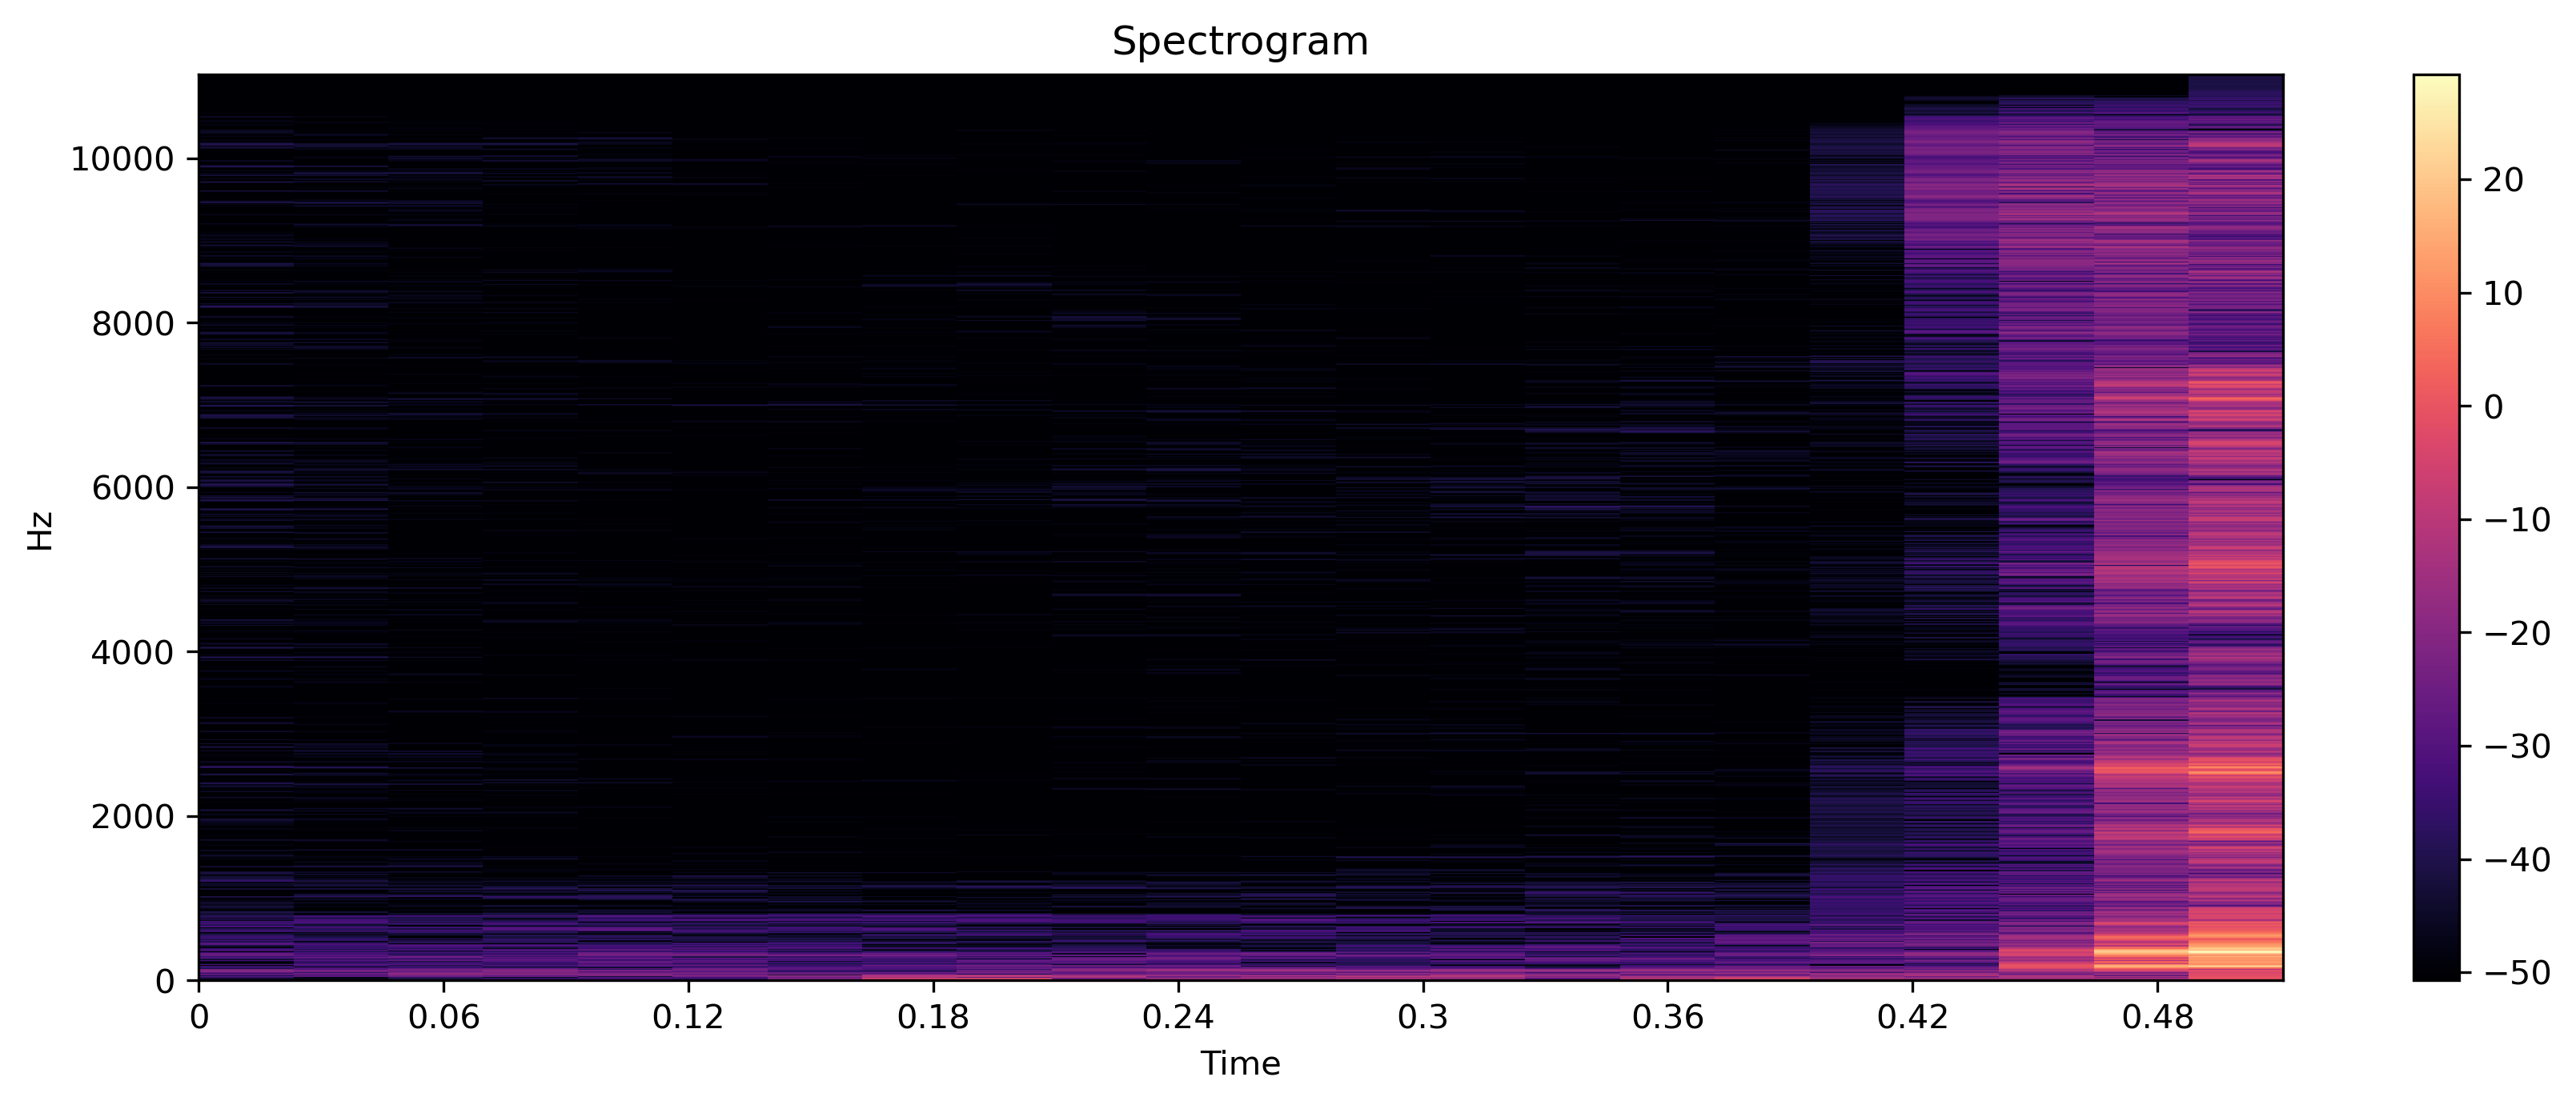

In [71]:
# #plot the wave and spectrogram
# #load audio using librosa
# # x, sr = librosa.load("./Voice Samples/Read Text/PD/ID02_pd_2_0_0.wav")
# # x, sr = loadAudio("./Voice Samples/Read Text/PD/ID02_pd_2_0_0.wav"
# x, sr = loadAudio("./Spectograms/Read Text/PD/Audio/ID02_1_1283.wav")
# # disaplayWavePlot(x, sr)
# displaySpectrogram(x, sr)

In [6]:
def getDir(type_of_text, parentDir):
    current_directory = os.getcwd()
    parent_directory = current_directory + "/" + parentDir
    parent_read_directory = parent_directory + "/" + "Read Text"
    parent_read_hc_directory = parent_read_directory + "/" + "HC"
    parent_read_pd_directory = parent_read_directory + "/" + "PD"
    parent_sp_directory = parent_directory + "/" + "Spontaneous"
    parent_sp_hc_directory = parent_sp_directory + "/" + "HC"
    parent_sp_pd_directory = parent_sp_directory + "/" + "PD"
    
    return {
        'ReadText_HC': parent_read_hc_directory,
        'ReadText_PD': parent_read_pd_directory,
        'Spontaneous_HC': parent_sp_hc_directory,
        'Spontaneous_PD': parent_sp_pd_directory,
    }[type_of_text]

In [7]:
def chunk_sound(filePath, type_of_text, parentDir):
    current_directory = os.getcwd()    
    
    files = [f for f in listdir(filePath) if isfile(join(filePath, f))]    
    
    destination_folder = getDir(type_of_text, parentDir)    

    cnt=0
    for file in files:
        os.chdir(current_directory)
        soundpath = filePath + "/" + file
#         soundpath = os.path.join(filePath, file)
        print(soundpath)
#         sound = AudioSegment.from_file(soundpath)
        sound = AudioSegment.from_wav(soundpath)
    
        os.chdir(destination_folder)
        
        sound_folder = file.split('.')[0]
        check_file_folder = os.path.isdir(sound_folder)
        
        if check_file_folder:
            print("Folder already exists")
        else:
            os.makedirs(sound_folder)
            print("Folder created - ", sound_folder)
        
        working_folder = destination_folder+"/"+sound_folder
        
        os.chdir(working_folder)
        
        #printing sound properties
        sound_properties(sound)
        
        #get the chunks by splitting on silence of 500ms and threshold of -53
        chunks = split_on_silence(sound, min_silence_len = 500, silence_thresh = -53)
        complete_audio = None
        
        for i, chunk in enumerate(chunks):
            chunk_name = "chunk{0}.wav".format(i)
            chunk.export(chunk_name, format="wav")
            if complete_audio:
                complete_audio = complete_audio + chunk
            else:
                complete_audio = chunk
            
        os.chdir(current_directory)
        
        save_processed_audio(complete_audio, type_of_text, file)
        
#         os.chdir(destination_folder)
        
    os.chdir(current_directory)

In [8]:
def save_processed_audio(processedAudio, type_of_text, file):
    destination_folder = getDir(type_of_text, 'ProcessedAudio')
    print(destination_folder)
    
    os.chdir(destination_folder)
    processedAudio.export(file, format="wav")

###### Chunking sound based on silence to cut off all the background noises

In [9]:
# chunk_sound("C:\\Users\\arauthan\\Research - PD\\Voice Samples\\Read Text\\HC", "ReadText_HC", "Chunks")
# chunk_sound("C:\\Users\\arauthan\\Research - PD\\Voice Samples\\Read Text\\PD", "ReadText_PD", "Chunks")
# chunk_sound("C:\\Users\\arauthan\\Research - PD\\Voice Samples\\SpontaneousDialogue\\HC", "Spontaneous_HC", "Chunks")
# chunk_sound("C:\\Users\\arauthan\\Research - PD\\Voice Samples\\SpontaneousDialogue\\PD", "Spontaneous_PD", "Chunks")

chunk_sound("./Voice Samples/Read Text/HC", "ReadText_HC", "Chunks")
chunk_sound("./Voice Samples/Read Text/PD", "ReadText_PD", "Chunks")
chunk_sound("./Voice Samples/SpontaneousDialogue/HC", "Spontaneous_HC", "Chunks")
chunk_sound("./Voice Samples/SpontaneousDialogue/PD", "Spontaneous_PD", "Chunks")

./Voice Samples/Read Text/HC/ID05_hc_0_0_0.wav
Folder already exists
-38.61543057469739 4891877.0 8820.0 44.1
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC
./Voice Samples/Read Text/HC/ID35_hc_0_0_0.wav
Folder already exists
-39.951424948130416 4111804.0 8820.0 44.1
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC
./Voice Samples/Read Text/HC/ID26_hc_0_0_0.wav
Folder already exists
-40.19153905580496 6779966.0 8820.0 44.1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-7cc82c593fed>", line 6, in <module>
    chunk_sound("./Voice Samples/Read Text/HC", "ReadText_HC", "Chunks")
  File "<ipython-input-7-d91059ab5b76>", line 43, in chunk_sound
    chunks = split_on_silence(sound, min_silence_len = 500, silence_thresh = -53)
  File "/opt/conda/lib/python3.7/site-packages/pydub/silence.py", line 150, in split_on_silence
    in detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step)
  File "/opt/conda/lib/python3.7/site-packages/pydub/silence.py", line 86, in detect_nonsilent
    silent_ranges = detect_silence(audio_segment, min_silence_len, silence_thresh, seek_step)
  File "/opt/conda/lib/python3.7/site-packages/pydub/silence.py", line 43, in detect_silence
    if audio_slice.rms <= silence_thresh:
  File "/opt/conda/lib

TypeError: object of type 'NoneType' has no len()

#### Retrieve MFCCS Attributes

In [9]:
def getMFCCS(audioTimeSeries,features_to_extract):
    mfccs = librosa.feature.mfcc(audioTimeSeries,sr=44100,n_mfcc=features_to_extract)
    return mfccs

In [10]:
def getDataFrame(feature_set, category):
    df=pd.DataFrame(data=feature_set[0:,0:],
               index = [i for i in range(feature_set.shape[0])],
               columns=['f'+str(i) for i in range(feature_set.shape[1])])
    df_T = df.T  
    df_T['Category'] = category    
    return df_T

In [11]:
def getMFCCS_allFiles(type_of_text, parent_folder, category):
    #destination_folder = getDir('ReadText_HC', 'ProcessedAudio')
    destination_folder = getDir(type_of_text, parent_folder)
    print(destination_folder)
    files = [f for f in listdir(destination_folder) if isfile(join(destination_folder, f))]
    
    df_mfccs_all = None
    
    for file in files:
        filedir = destination_folder + "/" + file
        x , sr = librosa.load(filedir)

        mfccs = getMFCCS(x,13)

        df_mfccs = getDataFrame(mfccs, category)

        if df_mfccs_all is None:
            df_mfccs_all = df_mfccs
        else:
            df_mfccs_all = df_mfccs_all.append(df_mfccs, ignore_index=True)
        
        #print(df_mfccs.shape)
        
    #print(df_mfccs_all.shape)
    
    #display(df_mfccs_all)
    return df_mfccs_all

In [12]:
def startTime(msg):
    start_time = datetime.datetime.now()
    print(" ====Start======= ", msg)
    print(" Start Time ", start_time)
    return start_time

In [13]:
def endTime(msg):
    end_time = datetime.datetime.now()
    print(" ====End======= ", msg)
    print(" End Time ", end_time)
    return end_time

In [14]:
def totalTime(msg, startTime, endTime):
    total_time = endTime - startTime
    print(msg, "=====Total Time=====", total_time)

In [15]:
# start_time = datetime.datetime.now()
msg = "Get MFCCS Details"
start_time = startTime(msg)

# getting mfccs for all the different categories
rt_hc_mfccs = getMFCCS_allFiles('ReadText_HC', 'ProcessedAudio', 0)
rt_pd_mfccs = getMFCCS_allFiles('ReadText_PD', 'ProcessedAudio', 1)
sp_hc_mfccs = getMFCCS_allFiles('Spontaneous_HC', 'ProcessedAudio', 0)
sp_pd_mfccs = getMFCCS_allFiles('Spontaneous_PD', 'ProcessedAudio', 1)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)
# print(total_time)
print(rt_hc_mfccs.shape, rt_pd_mfccs.shape, sp_hc_mfccs.shape, sp_pd_mfccs.shape)

 ====Start=======  Get MFCCS Details
 Start Time  2021-06-12 18:55:04.515416
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/PD
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Spontaneous/HC
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Spontaneous/PD
 ====End=======  Get MFCCS Details
 End Time  2021-06-12 18:58:49.977183
Get MFCCS Details =====Total Time===== 0:03:45.461767
(94832, 14) (56861, 14) (61658, 14) (45836, 14)


In [16]:
# appending all the mfccs for final DF for mfccs
df_final_mfccs = rt_hc_mfccs.append(rt_pd_mfccs, ignore_index=True)
df_final_mfccs = df_final_mfccs.append(sp_hc_mfccs, ignore_index=True)
df_final_mfccs = df_final_mfccs.append(sp_pd_mfccs, ignore_index=True)
print(df_final_mfccs.shape)

(259187, 14)


###### MFCCS - Checking the Imbalance in the data

Class 0: 156490
Class 1: 102697
Proportion: 1.52 : 1


Text(0, 0.5, 'Number of Data Points')

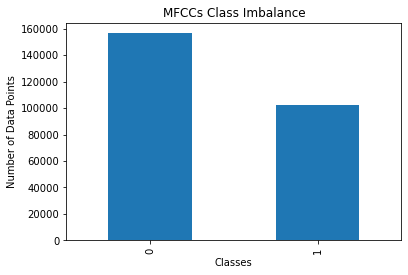

In [17]:
target_count = df_final_mfccs.Category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='MFCCs Class Imbalance');
plt.rcParams["figure.dpi"]=300
plt.xlabel("Classes")
plt.ylabel("Number of Data Points")

##### MFCCs - Splitting the Data into train, test and val

In [18]:
# Splitting the data in X and Y
X = df_final_mfccs.drop('Category', axis=1)
y = df_final_mfccs['Category']

In [19]:
print(X.shape, y.shape)

(259187, 13) (259187,)


In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.10)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20)

In [21]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(233268, 13) (25919, 13) (233268,) (25919,)


###### MFCCS - Balancing the Data

In [22]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(X_train_resampled.shape, y_train_resampled.shape)
print(type(X_train_resampled), type(y_train_resampled))

(184796, 13) (184796,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [23]:
df_train_resampled = X_train_resampled.copy()
df_train_resampled['Category'] = y_train_resampled

Class 0: 92398
Class 1: 92398
Proportion: 1.0 : 1


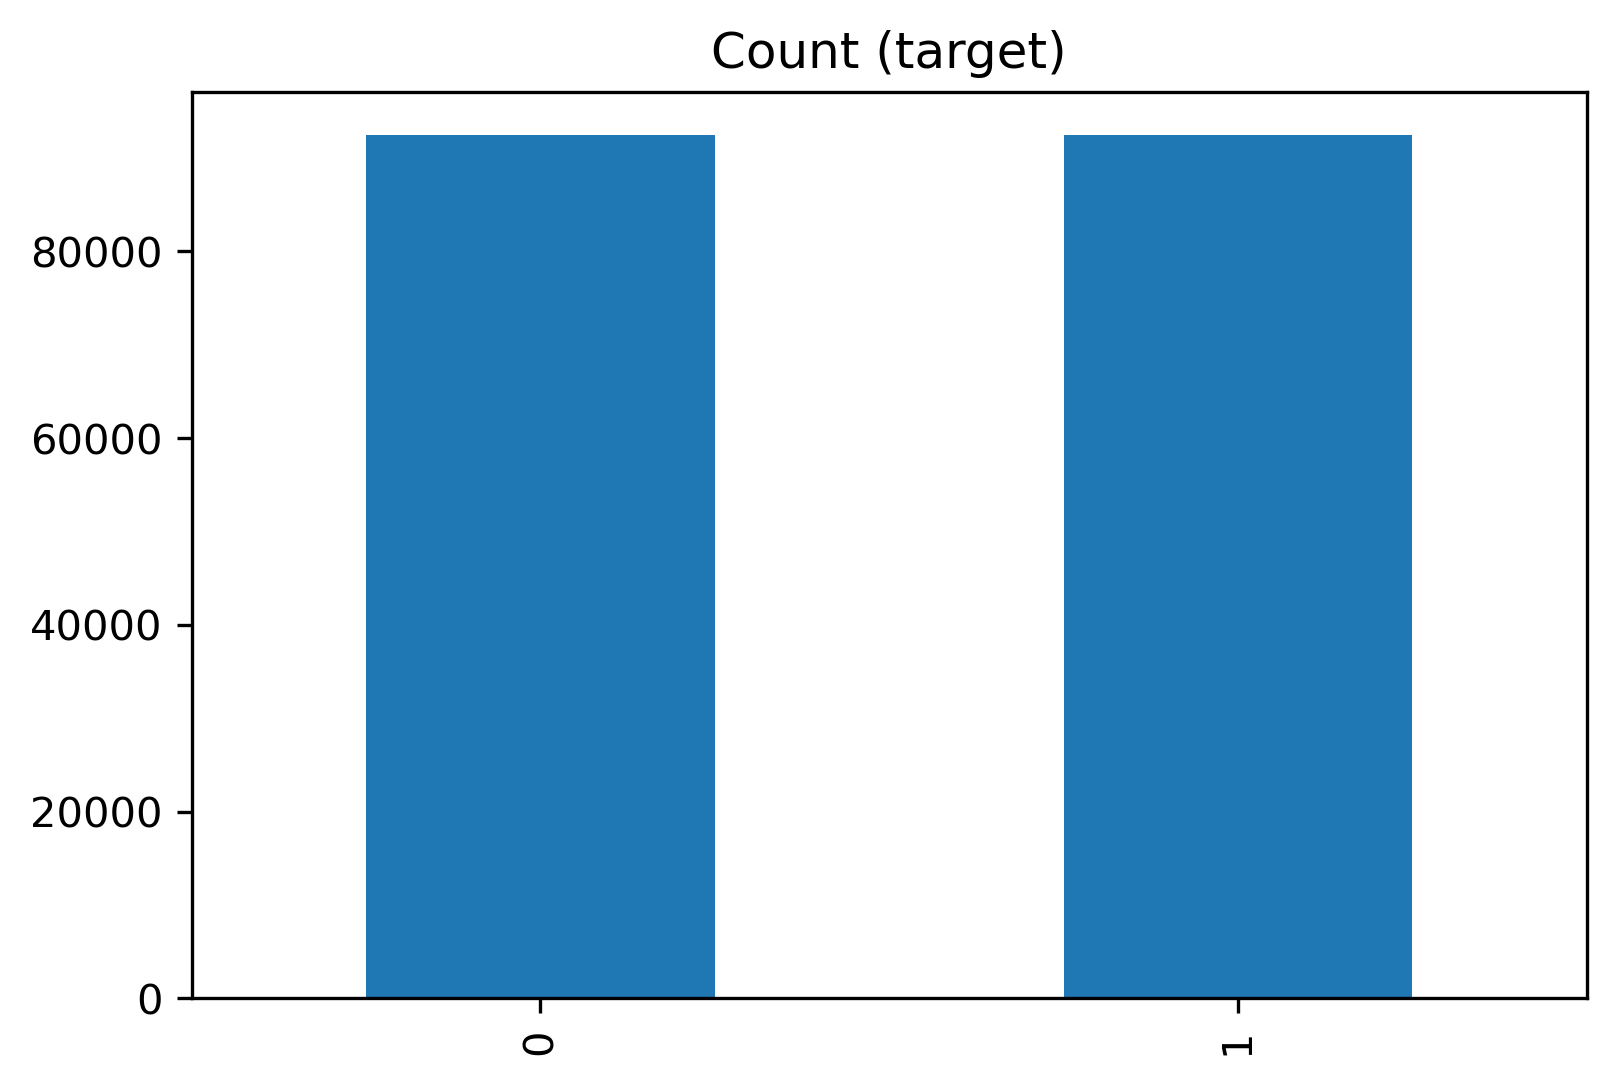

In [24]:
target_count = df_train_resampled.Category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [25]:
print(X.shape, y.shape, X_train_resampled.shape, X_val.shape, y_train_resampled.shape, y_val.shape)

(259187, 13) (259187,) (184796, 13) (25919, 13) (184796,) (25919,)


In [26]:
import gc
gc.collect()

3070

#### Normalize Datasets - Training and Testing datasets

In [27]:
# normalize the train and test dataset - X_train, X_test
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
def normalizeData(dataset):
    scaler = MinMaxScaler()
    scaler.fit(dataset)
    dataset_scaled = scaler.transform(dataset)
    return dataset_scaled

##### MFCCS - Normalizing Data

In [28]:
X_train_scaled = normalizeData(X_train_resampled)
X_val_scaled = normalizeData(X_val)
# X_scaled = normalizeData(X)

In [29]:
print(X.shape, y.shape, X_train_scaled.shape, X_val_scaled.shape, y_train.shape, y_train_resampled.shape, y_val.shape)

(259187, 13) (259187,) (184796, 13) (25919, 13) (233268,) (184796,) (25919,)


#### MFCCS - SVM with 5-fold cross validation

###### MFCCS - SVM - Linear

In [32]:
print(X_train_scaled.shape, y_train_resampled.shape)
print(X_train_scaled.max())

(184796, 13) (184796,)
1.0


In [33]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)
# print(X_resampled.shape, y_resampled.shape)
# print(type(X_resampled), type(y_resampled))

In [35]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train_resampled)
print(X_resampled.shape, y_resampled.shape)
print(type(X_resampled), type(y_resampled))

(80000, 13) (80000,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [34]:
C_range = 10. ** np.arange(-3, 8)
gamma_range = 10. ** np.arange(-5, 4)

param_grid = dict(gamma=gamma_range, C=C_range)
svc=SVC(kernel='linear')

# kfolds = StratifiedKFold(5)
# clf = GridSearchCV(estimator, parameters, scoring=qwk, cv=kfolds.split(xtrain,ytrain))
# clf.fit(xtrain, ytrain)

grid = GridSearchCV(svc, param_grid=param_grid, cv=StratifiedKFold(5).split(X_resampled,y_resampled))

grid.fit(X_resampled, y_resampled)

print("The best classifier is: ", grid.best_estimator_)

The best classifier is:  SVC(C=1000.0, gamma=1e-05, kernel='linear')


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [36]:
print(grid.cv_results_)

{'mean_fit_time': array([1.90800667e-02, 1.87711716e-02, 1.82110786e-02, 1.82030678e-02,
       1.84350014e-02, 1.81389332e-02, 1.81841850e-02, 1.85191631e-02,
       1.83151245e-02, 1.83470726e-02, 1.84264183e-02, 1.83626175e-02,
       1.83034897e-02, 1.84194565e-02, 1.82344913e-02, 1.82697296e-02,
       1.82609081e-02, 1.82559967e-02, 1.82655334e-02, 1.82608604e-02,
       1.83874607e-02, 1.82339191e-02, 1.82225227e-02, 1.84234142e-02,
       1.83630943e-02, 1.87371254e-02, 1.86980247e-02, 1.68109894e-02,
       1.68810844e-02, 1.68589115e-02, 1.69625759e-02, 1.67764664e-02,
       1.68835640e-02, 1.67850971e-02, 1.68107033e-02, 1.71070099e-02,
       1.75981045e-02, 1.78184986e-02, 1.77900791e-02, 1.77225113e-02,
       1.77365303e-02, 1.76795959e-02, 1.76462173e-02, 1.78299904e-02,
       1.76197529e-02, 3.50503922e-02, 3.49241734e-02, 3.49630356e-02,
       3.47470284e-02, 3.48579884e-02, 3.47243786e-02, 3.47289562e-02,
       3.48726749e-02, 3.47334862e-02, 1.46533775e-01, 1.48

In [37]:
print(grid.best_estimator_)

SVC(C=1000.0, gamma=1e-05, kernel='linear')


In [38]:
print(grid.best_score_)

0.7040000000000001


In [39]:
print(grid.best_params_)

{'C': 1000.0, 'gamma': 1e-05}


In [40]:
print(grid.best_index_)

54


In [45]:
C_range = 10. ** np.arange(-1, 4)
gamma_range = 10. ** np.arange(-3, 3)

param_grid = dict(gamma=gamma_range, C=C_range)
svc=SVC(kernel='rbf')

# kfolds = StratifiedKFold(5)
# clf = GridSearchCV(estimator, parameters, scoring=qwk, cv=kfolds.split(xtrain,ytrain))
# clf.fit(xtrain, ytrain)

grid = GridSearchCV(svc, param_grid=param_grid, cv=StratifiedKFold(5).split(X_resampled,y_resampled))

grid.fit(X_resampled, y_resampled)

print("The best classifier is: ", grid.best_estimator_)

The best classifier is:  SVC(C=1000.0, gamma=0.1)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

##### MFCCS - Train SVM Linear Model

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train_resampled)
print(X_resampled.shape, y_resampled.shape)
print(type(X_resampled), type(y_resampled))

In [33]:
msg = "SVM - 5 fold cross validation Linear Training Model"
start_time = startTime(msg)

svc=SVC(kernel='linear')
scoring = ["accuracy", "precision", "recall"]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
scores = cross_validate(svc, X_resampled, y_resampled, scoring=scoring, cv=cv, return_train_score=True)
# svc.fit(X_resampled, y_resampled)
print(scores)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation Linear Training Model
 Start Time  2021-06-07 20:41:07.141246
{'fit_time': array([108.79930735, 107.52987671, 106.99064374, 109.36135912,
       106.65539432]), 'score_time': array([16.38522744, 16.27266908, 16.18666959, 16.2809577 , 16.18437767]), 'test_accuracy': array([0.7033125, 0.7104375, 0.706125 , 0.706625 , 0.7068125]), 'train_accuracy': array([0.7054375 , 0.70267187, 0.704     , 0.70404687, 0.70434375]), 'test_precision': array([0.75167187, 0.74918759, 0.74342891, 0.74355151, 0.75593824]), 'train_precision': array([0.74359838, 0.74105615, 0.74210487, 0.74214302, 0.7424214 ]), 'test_recall': array([0.62183428, 0.63344573, 0.62521979, 0.62642884, 0.62562968]), 'train_recall': array([0.62332894, 0.622855  , 0.62638117, 0.62648647, 0.62185744])}
 ====End=======  SVM - 5 fold cross validation Linear Training Model
 End Time  2021-06-07 20:56:53.184576
SVM - 5 fold cross validation Linear Training Model =====Total Time===== 0:15:46.04

In [34]:
X_folds=np.arange(1,6,1)
Y_accuracy = scores['test_accuracy']
Y_precision = scores['test_precision']
Y_recall = scores['test_recall']
print(X_folds)
print(Y_accuracy)
print(Y_precision)
print(Y_recall)

[1 2 3 4 5]
[0.7033125 0.7104375 0.706125  0.706625  0.7068125]
[0.75167187 0.74918759 0.74342891 0.74355151 0.75593824]
[0.62183428 0.63344573 0.62521979 0.62642884 0.62562968]


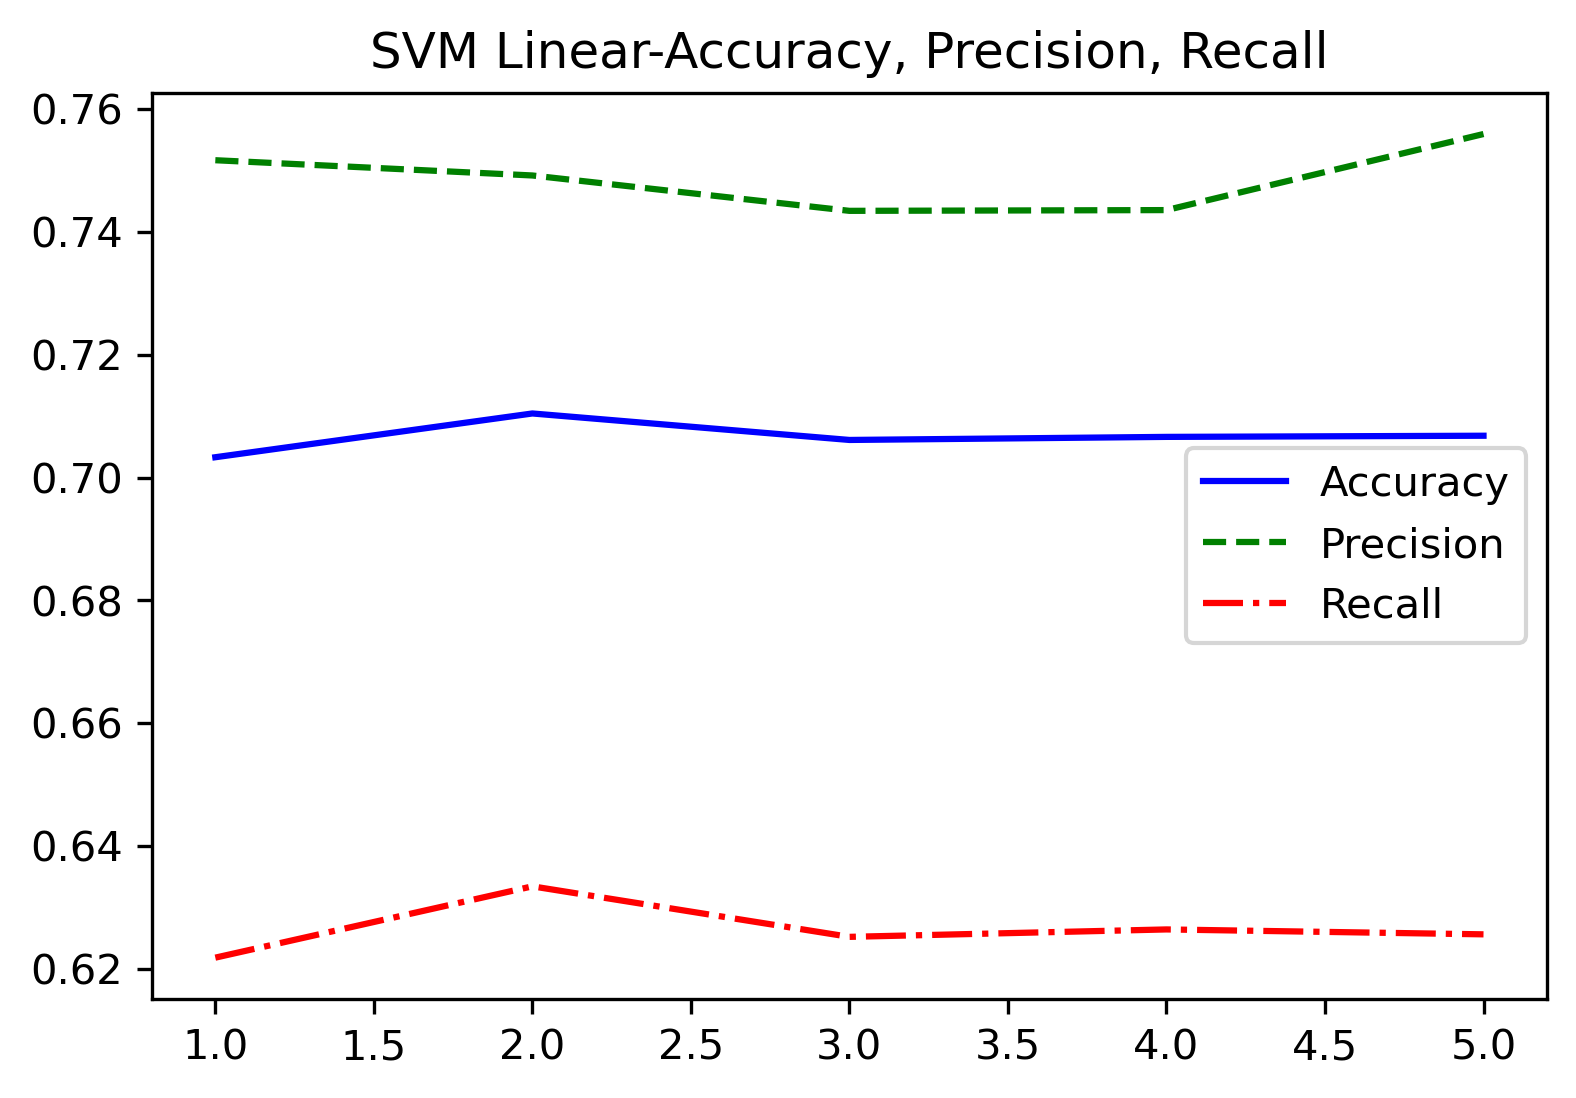

In [35]:
plt.plot(X_folds, Y_accuracy, label="Accuracy", linestyle="-", color="blue")
plt.plot(X_folds, Y_precision, label="Precision", linestyle="--", color="green")
plt.plot(X_folds, Y_recall, label="Recall", linestyle="-.", color="red")
plt.legend()
plt.title("SVM Linear-Accuracy, Precision, Recall")
# plt.figure(dpi=800)
plt.rcParams["figure.dpi"]=300
plt.show()

In [36]:
mean_test_accuracy = np.mean(scores['test_accuracy'])
mean_test_precision = np.mean(scores['test_precision'])
mean_test_recall = np.mean(scores['test_recall'])

In [37]:
print(mean_test_accuracy)
print(mean_test_precision)
print(mean_test_recall)

0.7066625
0.7487556257522483
0.6265116659433655


##### MFCCS - Testing SVM Linear Model

In [38]:
## Normalizing the validation dataset
print(X_val.shape, y_val.shape)
# X_val_scaled = normalizeData(X_val)
print(X_val_scaled.shape, X_val_scaled.max(), y_val.shape)

(25919, 13) (25919,)
(25919, 13) 1.0 (25919,)


In [39]:
## fitting the svm linear model
start_time = datetime.datetime.now()

svc.fit(X_train_scaled, y_train_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:15:04.670989


In [40]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = svc.predict(X_val_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:01:16.248698


In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_val, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_val, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_val, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_val, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(matrix)

Accuracy: 0.648250
Precision: 0.541168
Recall: 0.759410
F1 score: 0.631978
Cohens kappa: 0.312833
ROC AUC: 0.667131
[[8974 6637]
 [2480 7828]]


##### MFCCS - Train SVM RBF Model

In [44]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train_resampled)
print(X_resampled.shape, y_resampled.shape)
print(type(X_resampled), type(y_resampled))

(80000, 13) (80000,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [45]:
print(X_resampled.max())

1.0


In [47]:
msg = "SVM - 5 fold cross validation RBF Training Model"
start_time = startTime(msg)

svc=SVC(kernel='rbf')
scoring = ["accuracy", "precision", "recall"]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
scores = cross_validate(svc, X_resampled, y_resampled, scoring=scoring, cv=cv, return_train_score=True)
# svc.fit(X_resampled, y_resampled)
print(scores)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation RBF Training Model
 Start Time  2021-06-07 21:15:32.101226
{'fit_time': array([146.89881587, 142.53197122, 139.50739026, 143.22865105,
       141.71344972]), 'score_time': array([30.45824122, 30.21077442, 30.16076064, 30.30497122, 30.08000469]), 'test_accuracy': array([0.8045625, 0.804875 , 0.8024375, 0.801625 , 0.800875 ]), 'train_accuracy': array([0.81003125, 0.81020313, 0.811     , 0.811     , 0.81048438]), 'test_precision': array([0.84469228, 0.83620096, 0.83681774, 0.83036577, 0.83461694]), 'train_precision': array([0.84332102, 0.84276339, 0.84311769, 0.8423691 , 0.84185724]), 'test_recall': array([0.75424146, 0.75871113, 0.74905803, 0.75568396, 0.75893844]), 'train_recall': array([0.75958702, 0.76260432, 0.76474811, 0.76575424, 0.76256238])}
 ====End=======  SVM - 5 fold cross validation RBF Training Model
 End Time  2021-06-07 21:40:02.121478
SVM - 5 fold cross validation RBF Training Model =====Total Time===== 0:24:30.020252


In [48]:
X_folds=np.arange(1,6,1)
Y_accuracy = scores['test_accuracy']
Y_precision = scores['test_precision']
Y_recall = scores['test_recall']
print(X_folds)
print(Y_accuracy)
print(Y_precision)
print(Y_recall)


[1 2 3 4 5]
[0.8045625 0.804875  0.8024375 0.801625  0.800875 ]
[0.84469228 0.83620096 0.83681774 0.83036577 0.83461694]
[0.75424146 0.75871113 0.74905803 0.75568396 0.75893844]


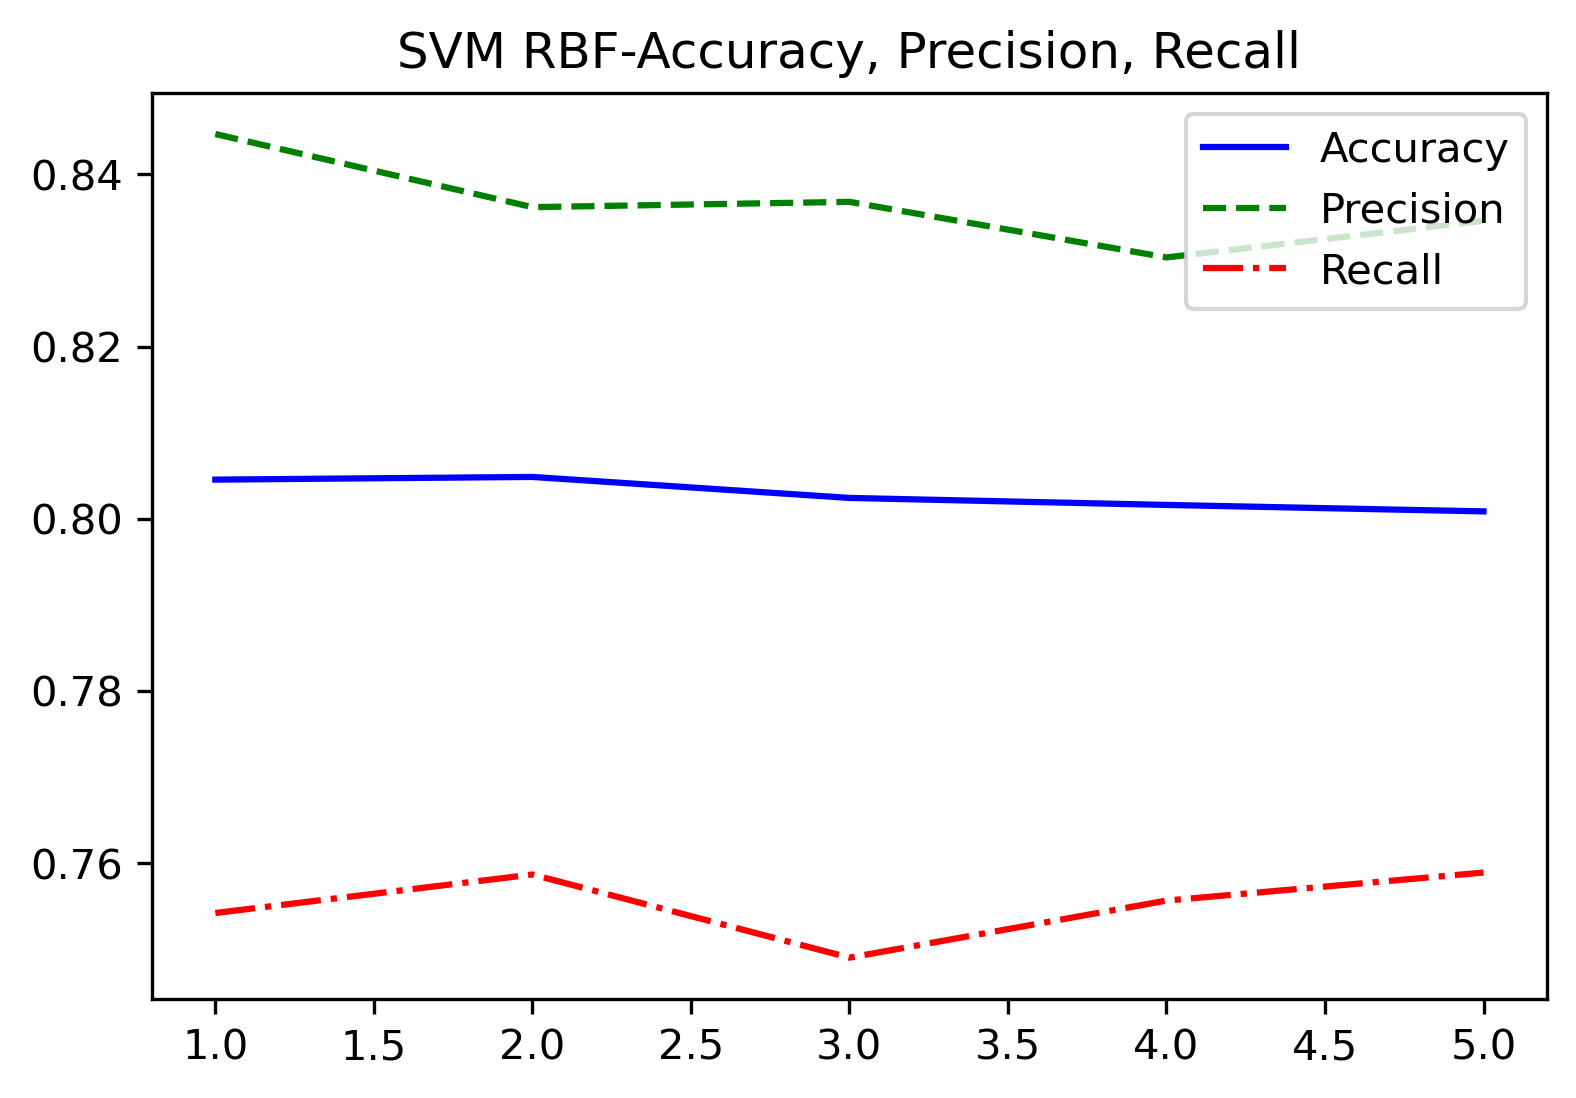

In [49]:
plt.plot(X_folds, Y_accuracy, label="Accuracy", linestyle="-", color="blue")
plt.plot(X_folds, Y_precision, label="Precision", linestyle="--", color="green")
plt.plot(X_folds, Y_recall, label="Recall", linestyle="-.", color="red")
plt.legend()
plt.title("SVM RBF-Accuracy, Precision, Recall")
# plt.figure(dpi=800)
plt.rcParams["figure.dpi"]=300
plt.show()

In [50]:
mean_test_accuracy = np.mean(scores['test_accuracy'])
mean_test_precision = np.mean(scores['test_precision'])
mean_test_recall = np.mean(scores['test_recall'])

In [51]:
print(mean_test_accuracy)
print(mean_test_precision)
print(mean_test_recall)

0.8028749999999999
0.836538737593556
0.7553266025662504


##### MFCCS - Testing SVM RBF Model

In [53]:
## fitting the svm linear model
start_time = datetime.datetime.now()

svc.fit(X_train_scaled, y_train_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:18:18.402649


In [52]:
print(X_val_scaled.max())

1.0


In [54]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = svc.predict(X_val_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:02:11.154978


In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_val, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_val, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_val, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_val, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(matrix)

Accuracy: 0.762877
Precision: 0.655600
Recall: 0.850601
F1 score: 0.740478
Cohens kappa: 0.528837
ROC AUC: 0.777777
[[11005  4606]
 [ 1540  8768]]


##### MFCCS - Train Extra Tree Classifier

In [57]:
seed = 7
kfold = KFold(n_splits = 5, random_state = seed, shuffle = True)

In [58]:
num_trees = 200
max_features = 12

In [59]:
model = ExtraTreesClassifier(n_estimators = num_trees, max_features = max_features)

In [60]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train_resampled)
print(X_resampled.shape, y_resampled.shape)
print(type(X_resampled), type(y_resampled))

(80000, 13) (80000,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [61]:
print(X_resampled.max())

1.0


In [62]:
msg = "Extra Tree Classifier"
start_time = startTime(msg)
scoring = ["accuracy", "precision", "recall"]
# results = cross_val_score(model, X_scaled, y, cv = kfold, scoring=scoring)
results = cross_validate(model, X_resampled, y_resampled, scoring=scoring, cv=kfold, return_train_score=True)

# print(results.mean())

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  Extra Tree Classifier
 Start Time  2021-06-07 22:08:48.076158
 ====End=======  Extra Tree Classifier
 End Time  2021-06-07 22:11:15.308306
Extra Tree Classifier =====Total Time===== 0:02:27.232148


In [63]:
print(results)

{'fit_time': array([25.42644763, 25.64660835, 25.46817923, 25.52249384, 25.58204079]), 'score_time': array([0.87361121, 0.86931396, 0.87355709, 0.86628795, 0.86930728]), 'test_accuracy': array([0.814875 , 0.819    , 0.816125 , 0.814875 , 0.8183125]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.83969363, 0.84105249, 0.83951613, 0.83994602, 0.84412082]), 'train_precision': array([1., 1., 1., 1., 1.]), 'test_recall': array([0.77937141, 0.78538298, 0.781336  , 0.778     , 0.78142554]), 'train_recall': array([1., 1., 1., 1., 1.])}


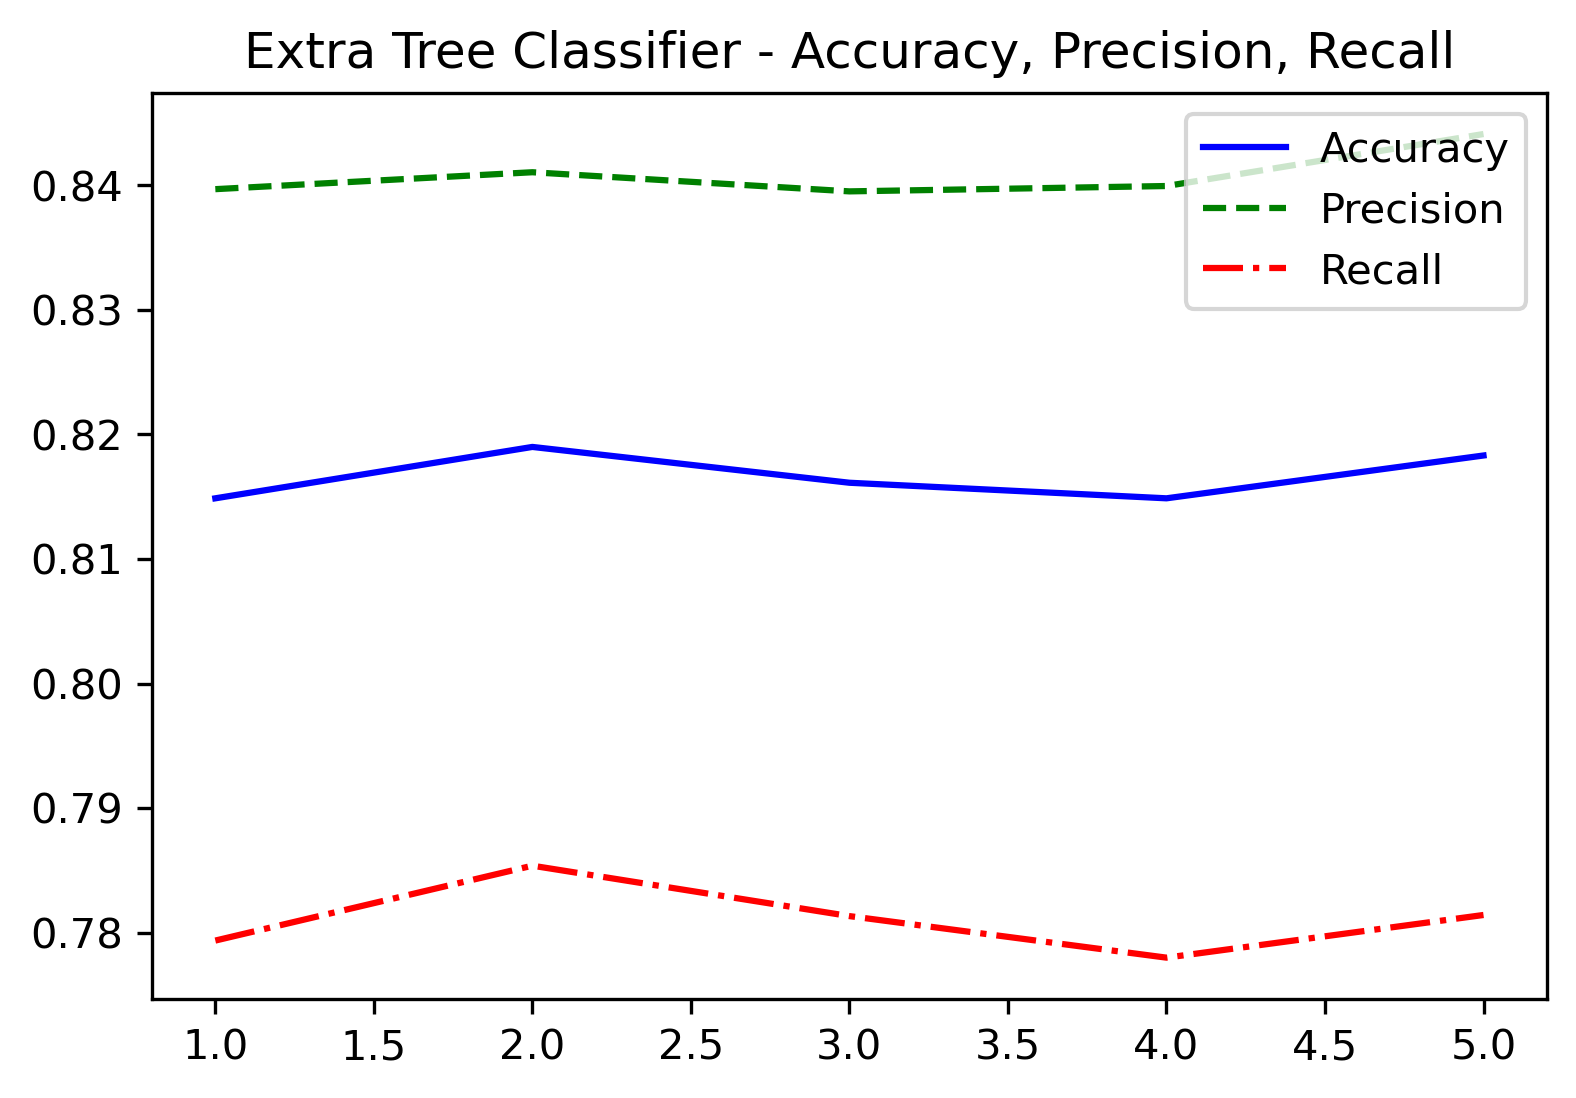

In [64]:
X_folds=np.arange(1,6,1)
Y_accuracy = results['test_accuracy']
Y_precision = results['test_precision']
Y_recall = results['test_recall']
plt.plot(X_folds, Y_accuracy, label="Accuracy", linestyle="-", color="blue")
plt.plot(X_folds, Y_precision, label="Precision", linestyle="--", color="green")
plt.plot(X_folds, Y_recall, label="Recall", linestyle="-.", color="red")
plt.legend()
plt.title("Extra Tree Classifier - Accuracy, Precision, Recall")
# plt.figure(dpi=800)
plt.rcParams["figure.dpi"]=300
plt.show()

In [65]:
mean_test_accuracy = np.mean(results['test_accuracy'])
mean_test_precision = np.mean(results['test_precision'])
mean_test_recall = np.mean(results['test_recall'])

In [66]:
print(mean_test_accuracy)
print(mean_test_precision)
print(mean_test_recall)

0.8166375
0.8408658177572388
0.7811031864516218


##### MFCCS - Testing Extra Tree Classifier

In [68]:
print(X_resampled.max(), X_train_scaled.max(), X_train_scaled.shape, y_train_resampled.shape)

1.0 1.0 (184778, 13) (184778,)


In [69]:
## fitting the extra tree classifier  model
start_time = datetime.datetime.now()

model.fit(X_train_scaled, y_train_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:01:19.457234


In [70]:
print(X_val_scaled.max())

1.0


In [71]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = model.predict(X_val_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:00:01.667583


In [72]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_val, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_val, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_val, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_val, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(matrix)

Accuracy: 0.783865
Precision: 0.684260
Recall: 0.847691
F1 score: 0.757258
Cohens kappa: 0.566433
ROC AUC: 0.794706
[[11579  4032]
 [ 1570  8738]]


##### MFCCS - Train Conv 1D Model

In [32]:
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D , MaxPool1D , Flatten , Dropout, Activation, BatchNormalization, MaxPooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.optimizers import SGD, RMSprop
import time

In [39]:
X_train_conv1D = np.expand_dims(X_train_scaled, axis=2)
X_val_conv1D = np.expand_dims(X_val_scaled, axis=2)

In [40]:
import keras_metrics
dense_layer = 1
layer_size = 128
conv_layer = 3

NAME = "MFCCs - Conv1D Model - {}".format(int(time.time()))
print(NAME)
tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))

model = Sequential()
model.add(Conv1D(layer_size, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=X_train_conv1D.shape[1:]))
model.add(MaxPool1D())

for l in range(conv_layer-1):
    model.add(Conv1D(layer_size, 3, padding="same", activation="relu"))
    model.add(MaxPool1D())

model.add(Dropout(0.4))

model.add(Flatten())

for d in range(dense_layer):
    model.add(Dense(layer_size,activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()

opt = SGD(lr=0.001)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

MFCCs - Conv1D Model - 1623534467
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)   

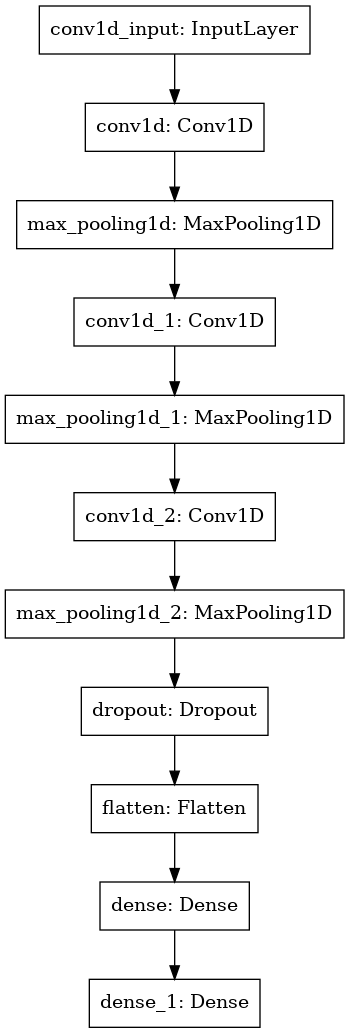

In [42]:
from keras.utils import plot_model
plot_model(model, to_file='CNN-1D-model.png')

In [39]:
X_CV = np.array(X_train_scaled)
y_CV = np.array(y_train_resampled)
print(X_CV.shape, type(X_CV), y_CV.shape, type(y_CV))

(184682, 13) <class 'numpy.ndarray'> (184682,) <class 'numpy.ndarray'>


In [40]:
print(X_CV.max())

1.0


In [41]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
for train_index, val_index in skf.split(np.zeros(len(X_CV)),y_CV):
    print("****Modelling Starts*****")

    X_train_CV = X_CV[train_index]
    X_test_CV = X_CV[val_index]
    
    y_train_CV = y_CV[train_index]
    y_test_CV = y_CV[val_index]
    
#     rus = RandomUnderSampler(random_state=0)
#     X_train_resampled_Conv1D, y_train_resampled_Conv1D = rus.fit_resample(X_train_CV, y_train_CV)
    
#     X_train_scaled_Conv1D = normalizeData(X_train_resampled)
#     X_test_scaled_Conv1D = normalizeData(X_test_CV)
#     X_scaled_Conv1D = normalizeData(X_CV)
    
    X_train_conv1D = np.expand_dims(X_train_CV, axis=2)
    X_test_conv1D = np.expand_dims(X_test_CV, axis=2)    

    hist = model.fit(X_train_conv1D, y_train_CV, batch_size=32, epochs=20, validation_data=(X_test_conv1D, y_test_CV), callbacks=[tensorboard])
    
    fold += 1

****Modelling Starts*****
Epoch 1/20
4618/4618 [==============================] - 32s 4ms/step - loss: 0.6933 - accuracy: 0.5018 - precision: 0.5018 - recall: 0.1919 - val_loss: 0.6929 - val_accuracy: 0.5014 - val_precision: 0.1541 - val_recall: 0.5004
Epoch 2/20
4618/4618 [==============================] - 18s 4ms/step - loss: 0.6929 - accuracy: 0.5107 - precision: 0.5076 - recall: 0.6105 - val_loss: 0.6926 - val_accuracy: 0.5288 - val_precision: 0.1598 - val_recall: 0.4826
Epoch 3/20
4618/4618 [==============================] - 18s 4ms/step - loss: 0.6927 - accuracy: 0.5244 - precision: 0.5204 - recall: 0.5720 - val_loss: 0.6922 - val_accuracy: 0.5239 - val_precision: 0.1588 - val_recall: 0.4856
Epoch 4/20
4618/4618 [==============================] - 18s 4ms/step - loss: 0.6923 - accuracy: 0.5356 - precision: 0.5289 - recall: 0.6300 - val_loss: 0.6919 - val_accuracy: 0.5446 - val_precision: 0.1640 - val_recall: 0.4629
Epoch 5/20
4618/4618 [==============================] - 17s 4ms/st

Epoch 4/20
4618/4618 [==============================] - 17s 4ms/step - loss: 0.5436 - accuracy: 0.7260 - precision: 0.7688 - recall: 0.6488 - val_loss: 0.5467 - val_accuracy: 0.7204 - val_precision: 0.2638 - val_recall: 0.3375
Epoch 5/20
4618/4618 [==============================] - 17s 4ms/step - loss: 0.5423 - accuracy: 0.7266 - precision: 0.7689 - recall: 0.6456 - val_loss: 0.5439 - val_accuracy: 0.7239 - val_precision: 0.2834 - val_recall: 0.3138
Epoch 6/20
4618/4618 [==============================] - 17s 4ms/step - loss: 0.5417 - accuracy: 0.7265 - precision: 0.7684 - recall: 0.6452 - val_loss: 0.5440 - val_accuracy: 0.7241 - val_precision: 0.2927 - val_recall: 0.3038
Epoch 7/20
4618/4618 [==============================] - 17s 4ms/step - loss: 0.5411 - accuracy: 0.7276 - precision: 0.7702 - recall: 0.6451 - val_loss: 0.5424 - val_accuracy: 0.7234 - val_precision: 0.2709 - val_recall: 0.3299
Epoch 8/20
4618/4618 [==============================] - 17s 4ms/step - loss: 0.5401 - accura

Epoch 20/20
4618/4618 [==============================] - 17s 4ms/step - loss: 0.5139 - accuracy: 0.7427 - precision: 0.7796 - recall: 0.6740 - val_loss: 0.5130 - val_accuracy: 0.7435 - val_precision: 0.2705 - val_recall: 0.3639


In [43]:
val_acc_mean = np.mean(hist.history['val_accuracy'])
val_precision_mean = np.mean(hist.history['val_precision'])
val_recall_mean = np.mean(hist.history['val_recall'])

In [44]:
print(val_acc_mean, val_precision_mean, val_recall_mean)

0.7269466042518615 0.2716794446110725 0.3525670751929283


##### MFCCS - Testing Conv 1D Model

In [45]:
print(X_val_scaled.shape, X_val_scaled.max())
X_val_conv1D = np.expand_dims(X_val_scaled, axis=2)
print(X_val_conv1D.shape, X_val_conv1D.max())

(25919, 13) 1.0
(25919, 13, 1) 1.0


In [46]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the Conv1D model
y_pred_prob = model.predict(X_val_conv1D)
y_pred_classes = model.predict_classes(X_val_conv1D)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:00:01.521077


In [48]:
print(y_pred_prob[:,0])
print(y_pred_classes[:,0])

y_pred_prob = y_pred_prob[:,0]
y_pred_classes = y_pred_classes[:,0]

[0.31103367 0.1955628  0.49124876 ... 0.39742306 0.47656935 0.25354624]
[0 0 0 ... 0 0 0]


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, y_pred_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_val, y_pred_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_val, y_pred_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, y_pred_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_val, y_pred_classes)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_val, y_pred_prob)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_val, y_pred_classes)
print(matrix)

Accuracy: 0.683051
Precision: 0.571495
Recall: 0.826284
F1 score: 0.675668
Cohens kappa: 0.385289
ROC AUC: 0.815016
[[9147 6416]
 [1799 8557]]


#### GFCCS - Get GFCCS Feature Set

In [13]:
import scipy.io.wavfile
from spafe.utils import vis
from spafe.features.gfcc import gfcc

def getGFCCS(filePath):
    print(filePath)
    num_ceps = 13
    low_freq = 0
    high_freq = 2000
    nfilts = 24
    nfft = 512
    dct_type = 2,
    use_energy = False,
    lifter = 5
    normalize = False
    
    # read wav 
    fs, sig = scipy.io.wavfile.read(filePath)
    
    # compute features
    gfccs = gfcc(sig=sig,
                 fs=44000,
                 num_ceps=num_ceps,
                 nfilts=nfilts,
                 nfft=nfft,
                 low_freq=low_freq,
                 high_freq=high_freq,
                 dct_type=dct_type,
                 use_energy=use_energy,
                 lifter=lifter,
                 normalize=normalize)
    
    return gfccs

In [14]:
def getGFCCSDataFrame(feature_set, category):
    df=pd.DataFrame(data=feature_set[0:,0:],
               index = [i for i in range(feature_set.shape[0])],
               columns=['f'+str(i) for i in range(feature_set.shape[1])])
#     df_T = df.T  
    df['Category'] = category    
    return df

In [15]:
def getGFCCS_allFiles(type_of_text, parent_folder, category):
    #destination_folder = getDir('ReadText_HC', 'ProcessedAudio')
    destination_folder = getDir(type_of_text, parent_folder)
#     print(destination_folder)
    files = [f for f in listdir(destination_folder) if isfile(join(destination_folder, f))]
    
    df_gfccs_all = None
    
    for file in files:
        
        filedir = destination_folder + "/" + file        
        gfccs = getGFCCS(filedir)
        
#         print(gfccs.shape)
        
        #converting into dataframe
        df_gfccs = getGFCCSDataFrame(gfccs, category)

        if df_gfccs_all is None:
            df_gfccs_all = df_gfccs
        else:
            df_gfccs_all = df_gfccs_all.append(df_gfccs, ignore_index=True)
        
#         print(filedir)
#         x , sr = librosa.load(filedir)

#         mfccs = getMFCCS(x,13)

#         df_mfccs = getDataFrame(mfccs, category)

#         if df_mfccs_all is None:
#             df_mfccs_all = df_mfccs
#         else:
#             df_mfccs_all = df_mfccs_all.append(df_mfccs, ignore_index=True)
        
#         print(df_gfccs_all.shape)
        
#     print(df_gfccs_all.shape)
    
    #display(df_mfccs_all)
    return df_gfccs_all

In [16]:
# start_time = datetime.datetime.now()
msg = "Get GFCCS Details"
start_time = startTime(msg)

# getting mfccs for all the different categories
rt_hc_gfccs = getGFCCS_allFiles('ReadText_HC', 'ProcessedAudio', 0)
rt_pd_gfccs = getGFCCS_allFiles('ReadText_PD', 'ProcessedAudio', 1)
sp_hc_gfccs = getGFCCS_allFiles('Spontaneous_HC', 'ProcessedAudio', 0)
sp_pd_gfccs = getGFCCS_allFiles('Spontaneous_PD', 'ProcessedAudio', 1)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)
# print(total_time)
print(rt_hc_gfccs.shape, rt_pd_gfccs.shape, sp_hc_gfccs.shape, sp_pd_gfccs.shape)

 ====Start=======  Get GFCCS Details
 Start Time  2021-06-08 12:22:14.972006
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID05_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID35_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID26_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID11_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID15_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID14_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID19_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID21_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID00_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID36_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID25_hc_0_0_0.wav

In [17]:
print(rt_hc_gfccs.shape, rt_pd_gfccs.shape, sp_hc_gfccs.shape, sp_pd_gfccs.shape)

# appending all the gfccs for final DF for mfccs
df_final_gfccs = rt_hc_gfccs.append(rt_pd_gfccs, ignore_index=True)
df_final_gfccs = df_final_gfccs.append(sp_hc_gfccs, ignore_index=True)
df_final_gfccs = df_final_gfccs.append(sp_pd_gfccs, ignore_index=True)
print(df_final_gfccs.shape)

(220631, 14) (132282, 14) (143427, 14) (106627, 14)
(602967, 14)


In [18]:
df_final_gfccs

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,Category
0,33.553725,-327.282134,-537.965626,-540.709299,190.664838,-40.545762,-44.250206,-65.933163,111.558595,25.862517,61.608066,-123.491228,60.721341,0
1,32.937590,127.393039,-1037.770429,-166.557101,144.008282,-21.294702,-47.003629,16.499201,88.379308,13.119864,12.410824,81.672968,-85.314064,0
2,32.927673,307.843392,-217.038829,-367.628969,-137.590457,-40.416272,-20.524016,-7.769635,43.733566,-9.107398,-16.302603,-35.371148,0.232501,0
3,32.773580,428.340636,-48.744099,-166.526442,-124.606552,-45.513312,-14.756438,43.019880,-1.925314,-8.314402,-41.780739,42.407669,127.038360,0
4,32.721803,214.971019,-391.179252,-190.833275,-63.170231,1.646817,-39.693965,29.747607,47.428966,6.628665,-28.250850,85.909882,47.188737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602962,36.361998,3216.344417,2253.933780,1445.403321,219.359085,-43.258357,39.742362,184.888394,20.857250,-21.968884,-5.371907,53.454669,-193.129134,1
602963,34.114350,2069.502685,1026.265780,-337.938362,-7.364164,-5.276819,-35.845963,-31.653945,126.977836,9.108476,-10.034135,-66.909309,19.634265,1
602964,33.341491,1314.407792,340.235831,-5.616461,92.006486,74.108232,-55.417761,-7.007076,-10.401687,40.165033,-100.105128,-98.170749,-1.649237,1
602965,33.401556,1607.949531,590.045103,466.023109,221.558115,-17.202676,18.580917,-144.001833,-9.697481,32.230948,-95.143091,-116.333700,45.359464,1


In [19]:
df_final_gfccs.columns = ['gfccs_f0', 'gfccs_f1', 'gfccs_f2', 'gfccs_f3', 'gfccs_f4', 'gfccs_f5', 'gfccs_f6', 'gfccs_f7', 'gfccs_f8', 'gfccs_f9', 'gfccs_f10', 'gfccs_f11', 'gfccs_f12', 'Category']

In [20]:
df_final_gfccs

,gfccs_f0,gfccs_f1,gfccs_f2,gfccs_f3,gfccs_f4,gfccs_f5,gfccs_f6,gfccs_f7,gfccs_f8,gfccs_f9,gfccs_f10,gfccs_f11,gfccs_f12,Category
0,33.553725,-327.282134,-537.965626,-540.709299,190.664838,-40.545762,-44.250206,-65.933163,111.558595,25.862517,61.608066,-123.491228,60.721341,0
1,32.937590,127.393039,-1037.770429,-166.557101,144.008282,-21.294702,-47.003629,16.499201,88.379308,13.119864,12.410824,81.672968,-85.314064,0
2,32.927673,307.843392,-217.038829,-367.628969,-137.590457,-40.416272,-20.524016,-7.769635,43.733566,-9.107398,-16.302603,-35.371148,0.232501,0
3,32.773580,428.340636,-48.744099,-166.526442,-124.606552,-45.513312,-14.756438,43.019880,-1.925314,-8.314402,-41.780739,42.407669,127.038360,0
4,32.721803,214.971019,-391.179252,-190.833275,-63.170231,1.646817,-39.693965,29.747607,47.428966,6.628665,-28.250850,85.909882,47.188737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602962,36.361998,3216.344417,2253.933780,1445.403321,219.359085,-43.258357,39.742362,184.888394,20.857250,-21.968884,-5.371907,53.454669,-193.129134,1
602963,34.114350,2069.502685,1026.265780,-337.938362,-7.364164,-5.276819,-35.845963,-31.653945,126.977836,9.108476,-10.034135,-66.909309,19.634265,1
602964,33.341491,1314.407792,340.235831,-5.616461,92.006486,74.108232,-55.417761,-7.007076,-10.401687,40.165033,-100.105128,-98.170749,-1.649237,1
602965,33.401556,1607.949531,590.045103,466.023109,221.558115,-17.202676,18.580917,-144.001833,-9.697481,32.230948,-95.143091,-116.333700,45.359464,1


###### GFCCS - Splitting, Balancing and Normalizing Dataset

In [21]:
# Splitting the data in X and Y
X_gfccs = df_final_gfccs.drop('Category', axis=1)
y_gfccs = df_final_gfccs['Category']

In [22]:
X_gfccs_train, X_gfccs_test, y_gfccs_train, y_gfccs_test = train_test_split(X_gfccs, y_gfccs, test_size = 0.10)

Class 0: 364058
Class 1: 238909
Proportion: 1.52 : 1


Text(0, 0.5, 'Number of Data Points')

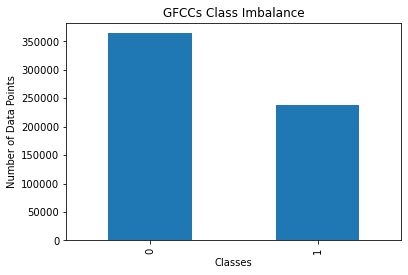

In [24]:
target_count = df_final_gfccs.Category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='GFCCs Class Imbalance');
plt.rcParams["figure.dpi"]=300
plt.xlabel("Classes")
plt.ylabel("Number of Data Points")


In [25]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_gfccs_train_resampled, y_gfccs_train_resampled = rus.fit_resample(X_gfccs_train, y_gfccs_train)
print(X_gfccs_train_resampled.shape, y_gfccs_train_resampled.shape)
print(type(X_gfccs_train_resampled), type(y_gfccs_train_resampled))

(429818, 13) (429818,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [26]:
X_gfccs_train_scaled = normalizeData(X_gfccs_train_resampled)
X_gfccs_test_scaled = normalizeData(X_gfccs_test)
X_gfccs_scaled = normalizeData(X_gfccs)

In [27]:
print(X_gfccs_scaled.shape, type(X_gfccs_scaled), X_gfccs_train_scaled.shape, X_gfccs_test_scaled.shape)

(602967, 13) <class 'numpy.ndarray'> (429818, 13) (60297, 13)


##### GFCCS - Train Conv 1D Model

In [88]:
X_gfccs_train_conv1D = np.expand_dims(X_gfccs_train_scaled, axis=2)
X_gfccs_test_conv1D = np.expand_dims(X_gfccs_test_scaled, axis=2)

In [117]:
import keras_metrics
dense_layer = 1
layer_size = 128
conv_layer = 3

NAME = "GFCCs - Conv1D Model - {}".format(int(time.time()))
print(NAME)
tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
model = Sequential()
model.add(Conv1D(layer_size, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=X_gfccs_train_conv1D.shape[1:]))
model.add(MaxPool1D())

for l in range(conv_layer-1):
    model.add(Conv1D(layer_size, 3, padding="same", activation="relu"))
    model.add(MaxPool1D())

model.add(Dropout(0.4))

model.add(Flatten())

for d in range(dense_layer):
    model.add(Dense(layer_size,activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)

# opt = SGD(lr=0.01)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

GFCCs - Conv1D Model - 1623111901
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 11, 128)           512       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2, 128)            49280     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
dropout_7 (Dropout) 

In [92]:
# X_gfccs_CV = np.array(X_gfccs)
# y_gfccs_CV = np.array(y_gfccs)
X_gfccs_CV = X_gfccs_train_scaled
y_gfccs_CV = y_gfccs_train_resampled

In [118]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
for train_index, val_index in skf.split(np.zeros(len(X_gfccs_CV)),y_gfccs_CV):
    print("****Modelling Starts*****")

    X_gfccs_train_CV = X_gfccs_CV[train_index]
    X_gfccs_test_CV = X_gfccs_CV[val_index]
    
    y_gfccs_train_CV = y_gfccs_CV[train_index]
    y_gfccs_test_CV = y_gfccs_CV[val_index]
    

    #transforming the data - 
    
#     rus = RandomUnderSampler(random_state=0)
#     X_gfccs_train_resampled, y_gfccs_train_resampled = rus.fit_resample(X_gfccs_train_CV, y_gfccs_train_CV)
#     print(X_train_resampled.shape, y_train_resampled.shape)
#     print(type(X_train_resampled), type(y_train_resampled))
    
#     X_gfccs_train_scaled = normalizeData(X_gfccs_train_resampled)
#     X_gfccs_test_scaled = normalizeData(X_gfccs_test_CV)
#     X_gfccs_scaled = normalizeData(X_gfccs_CV)
    
    X_gfccs_train_conv1D = np.expand_dims(X_gfccs_train_CV, axis=2)
    X_gfccs_test_conv1D = np.expand_dims(X_gfccs_test_CV, axis=2)
    
#     print(X_train_conv1D.shape, X_test_conv1D.shape, y_gfccs_train_CV.shape, y_gfccs_test_CV.shape)
    
    #model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))
    hist = model.fit(X_gfccs_train_conv1D, y_gfccs_train_CV, batch_size=32, epochs=20, validation_data=(X_gfccs_test_conv1D, y_gfccs_test_CV), callbacks=[tensorboard])
#     break
    
    fold += 1

****Modelling Starts*****
Epoch 1/20
10754/10754 [==============================] - 43s 4ms/step - loss: 0.6892 - accuracy: 0.5493 - precision: 0.5252 - recall: 0.6851 - val_loss: 0.6236 - val_accuracy: 0.6283 - val_precision: 0.1944 - val_recall: 0.3895
Epoch 2/20
10754/10754 [==============================] - 42s 4ms/step - loss: 0.6067 - accuracy: 0.6668 - precision: 0.6789 - recall: 0.5986 - val_loss: 0.5741 - val_accuracy: 0.6935 - val_precision: 0.2929 - val_recall: 0.2635
Epoch 3/20
10754/10754 [==============================] - 41s 4ms/step - loss: 0.5777 - accuracy: 0.6912 - precision: 0.7505 - recall: 0.5651 - val_loss: 0.5718 - val_accuracy: 0.6953 - val_precision: 0.3148 - val_recall: 0.2484
Epoch 4/20
10754/10754 [==============================] - 41s 4ms/step - loss: 0.5682 - accuracy: 0.6969 - precision: 0.7600 - recall: 0.5704 - val_loss: 0.5624 - val_accuracy: 0.6982 - val_precision: 0.2544 - val_recall: 0.3223
Epoch 5/20
10754/10754 [==============================] - 

Epoch 8/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5419 - accuracy: 0.7134 - precision: 0.7823 - recall: 0.5924 - val_loss: 0.5392 - val_accuracy: 0.7164 - val_precision: 0.2956 - val_recall: 0.2916
Epoch 9/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5416 - accuracy: 0.7140 - precision: 0.7814 - recall: 0.5948 - val_loss: 0.5389 - val_accuracy: 0.7165 - val_precision: 0.2908 - val_recall: 0.2970
Epoch 10/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5411 - accuracy: 0.7143 - precision: 0.7831 - recall: 0.5945 - val_loss: 0.5393 - val_accuracy: 0.7160 - val_precision: 0.2993 - val_recall: 0.2872
Epoch 11/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5414 - accuracy: 0.7141 - precision: 0.7827 - recall: 0.5914 - val_loss: 0.5389 - val_accuracy: 0.7163 - val_precision: 0.2973 - val_recall: 0.2901
Epoch 12/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.

Epoch 19/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5402 - accuracy: 0.7150 - precision: 0.7836 - recall: 0.5955 - val_loss: 0.5378 - val_accuracy: 0.7166 - val_precision: 0.2919 - val_recall: 0.2952
Epoch 20/20
10754/10754 [==============================] - 40s 4ms/step - loss: 0.5400 - accuracy: 0.7153 - precision: 0.7872 - recall: 0.5989 - val_loss: 0.5378 - val_accuracy: 0.7166 - val_precision: 0.2919 - val_recall: 0.2952


In [120]:
val_acc_mean = np.mean(hist.history['val_accuracy'])
val_precision_mean = np.mean(hist.history['val_precision'])
val_recall_mean = np.mean(hist.history['val_recall'])

In [121]:
print(val_acc_mean, val_precision_mean, val_recall_mean)

0.7165971249341965 0.2918633669614792 0.29516369849443436


##### GFCCS - Testing Conv 1D Model

In [124]:
X_gfccs_test_conv1D = np.expand_dims(X_gfccs_test_scaled, axis=2)
print(X_gfccs_test_conv1D.shape, y_gfccs_test.shape)

(60297, 13, 1) (60297,)


In [125]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the Conv1D model
y_pred_prob = model.predict(X_gfccs_test_conv1D)
y_pred_classes = model.predict_classes(X_gfccs_test_conv1D)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:00:03.388280


In [126]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_gfccs_test, y_pred_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_gfccs_test, y_pred_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_gfccs_test, y_pred_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_gfccs_test, y_pred_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_gfccs_test, y_pred_classes)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_gfccs_test, y_pred_prob)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_gfccs_test, y_pred_classes)
print(matrix)

Accuracy: 0.654145
Precision: 0.884784
Recall: 0.143708
F1 score: 0.247257
Cohens kappa: 0.153786
ROC AUC: 0.698339
[[36018   446]
 [20408  3425]]


##### GFCCS - Training SVM Linear Model

In [131]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_gfccs_resampled, y_gfccs_resampled = rus.fit_resample(X_gfccs_train_scaled, y_gfccs_train_resampled)
print(X_gfccs_resampled.shape, y_gfccs_resampled.shape)
print(type(X_gfccs_resampled), type(y_gfccs_resampled))

(80000, 13) (80000,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [132]:
msg = "SVM - 5 fold cross validation Linear Training Model (GFCCS)"
start_time = startTime(msg)

svc=SVC(kernel='linear')
scoring = ["accuracy", "precision", "recall"]
# scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
scores = cross_validate(svc, X_gfccs_resampled, y_gfccs_resampled, scoring=scoring, cv=5, return_train_score=True)
print(scores)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 Start Time  2021-06-08 05:02:17.560164
{'fit_time': array([104.62383223, 103.35814285, 103.34522653, 102.21927238,
       103.48540831]), 'score_time': array([16.78720093, 16.64687395, 16.68671179, 16.49727893, 16.56502962]), 'test_accuracy': array([0.6925625, 0.6841875, 0.6914375, 0.6853125, 0.6865   ]), 'train_accuracy': array([0.68729688, 0.68876563, 0.68667188, 0.68879687, 0.68845312]), 'test_precision': array([0.76194525, 0.75532837, 0.75452883, 0.75216874, 0.75618132]), 'train_precision': array([0.75564086, 0.75725054, 0.75407256, 0.75709605, 0.75649696]), 'test_recall': array([0.560125, 0.544875, 0.5675  , 0.55275 , 0.5505  ]), 'train_recall': array([0.553625  , 0.55565625, 0.55403125, 0.55596875, 0.5558125 ])}
 ====End=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 End Time  2021-06-08 05:17:50.865884
SVM - 5 fold cross validation Linear Training Model (GFCCS) =====Total Time==

In [133]:
mean_test_accuracy = np.mean(scores['test_accuracy'])
mean_test_precision = np.mean(scores['test_precision'])
mean_test_recall = np.mean(scores['test_recall'])
print("mean_test_accuracy ", mean_test_accuracy)
print("mean_test_precision ", mean_test_precision)
print("mean_test_recall ", mean_test_recall)

mean_test_accuracy  0.688
mean_test_precision  0.7560305006406413
mean_test_recall  0.55515


##### GFCCS - Testing SVM Linear Model

In [31]:
## fitting the svm linear model
start_time = datetime.datetime.now()
svc=SVC(kernel='linear')

svc.fit(X_gfccs_train_scaled, y_gfccs_train_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

1:43:01.291628


In [32]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = svc.predict(X_gfccs_test_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:06:59.597916


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_gfccs_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_gfccs_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_gfccs_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_gfccs_test, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_gfccs_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_gfccs_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_gfccs_test, y_pred)
print(matrix)


Accuracy: 0.396040
Precision: 0.395759
Recall: 0.999874
F1 score: 0.567067
Cohens kappa: 0.000552
ROC AUC: 0.500349
[[   30 36414]
 [    3 23850]]


##### GFCCS - Testing SVM RBF Model

In [ ]:
msg = "SVM - 5 fold cross validation Linear Training Model (GFCCS)"
start_time = startTime(msg)

svc=SVC(kernel='rbf')
scoring = ["accuracy", "precision", "recall"]
# scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
# scores = cross_validate(svc, X_gfccs_scaled, y_gfccs_resampled, scoring=scoring, cv=5, return_train_score=True)
scores = cross_validate(svc, X_gfccs_resampled, y_gfccs_resampled, scoring=scoring, cv=5, return_train_score=True)

print(scores)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

In [ ]:
mean_test_accuracy = np.mean(scores['test_accuracy'])
mean_test_precision = np.mean(scores['test_precision'])
mean_test_recall = np.mean(scores['test_recall'])
print("mean_test_accuracy ", mean_test_accuracy)
print("mean_test_precision ", mean_test_precision)
print("mean_test_recall ", mean_test_recall)

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 70000,
        1: 70000
    })
X_gfccs_resampled, y_gfccs_resampled = rus.fit_resample(X_gfccs_train_scaled, y_gfccs_train_resampled)
print(X_gfccs_resampled.shape, y_gfccs_resampled.shape)
print(type(X_gfccs_resampled), type(y_gfccs_resampled))

(140000, 13) (140000,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


##### GFCCS - Testing SVM RBF Model

In [29]:
## fitting the svm linear model
start_time = datetime.datetime.now()
svc=SVC(kernel='rbf')

# svc.fit(X_gfccs_train_scaled, y_gfccs_train_resampled)
svc.fit(X_gfccs_resampled, y_gfccs_resampled)


end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:11:30.212785


In [30]:
print(X_gfccs_test_scaled.shape)

(60297, 13)


In [31]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = svc.predict(X_gfccs_test_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:05:00.585732


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_gfccs_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_gfccs_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_gfccs_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_gfccs_test, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_gfccs_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_gfccs_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_gfccs_test, y_pred)
print(matrix)


Accuracy: 0.406703
Precision: 0.330678
Recall: 0.479042
F1 score: 0.391267
Cohens kappa: -0.150637
ROC AUC: 0.418957
[[13026 23271]
 [12503 11497]]


In [51]:
# msg = "SVM - Linear Training Model"
# start_time = startTime(msg)

# #training the svc linear model
# svclassifier = SVC(kernel='linear')
# svclassifier.fit(X_gfccs_train_scaled, y_gfccs_train)

# # end time
# end_time = endTime(msg)

# #total time
# totalTime(msg, start_time, end_time)

 ====Start=======  SVM - Linear Training Model
 Start Time  2021-05-15 04:53:42.732455
 ====End=======  SVM - Linear Training Model
 End Time  2021-05-15 06:38:13.213737
SVM - Linear Training Model =====Total Time===== 1:44:30.481282


In [52]:
# msg = "SVM - Linear Testing Model"
# start_time = startTime(msg)

# #testing the SVM model
# y_gfccs_pred = svclassifier.predict(X_gfccs_test_scaled)

# # end time
# end_time = endTime(msg)

# #total time
# totalTime(msg, start_time, end_time)

 ====Start=======  SVM - Linear Testing Model
 Start Time  2021-05-15 06:48:42.040555
 ====End=======  SVM - Linear Testing Model
 End Time  2021-05-15 07:07:42.033317
SVM - Linear Testing Model =====Total Time===== 0:18:59.992762


In [53]:
# from sklearn import metrics

# # Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_gfccs_test, y_gfccs_pred))

# # Model Precision: what percentage of positive tuples are labeled as such?
# print("Precision:",metrics.precision_score(y_gfccs_test, y_gfccs_pred))

# # Model Recall: what percentage of positive tuples are labelled as such?
# print("Recall:",metrics.recall_score(y_gfccs_test, y_gfccs_pred))

Accuracy: 0.6186930250814026
Precision: 0.9116365899191039
Recall: 0.0409097890283576


In [54]:
# msg = "SVM - RBF Training Model"
# start_time = startTime(msg)

# #training the svc linear model
# svclassifier = SVC(kernel='rbf')
# svclassifier.fit(X_gfccs_train_scaled, y_gfccs_train)

# # end time
# end_time = endTime(msg)

# #total time
# totalTime(msg, start_time, end_time)

 ====Start=======  SVM - RBF Training Model
 Start Time  2021-05-15 07:07:42.148446
 ====End=======  SVM - RBF Training Model
 End Time  2021-05-15 09:18:34.343725
SVM - RBF Training Model =====Total Time===== 2:10:52.195279


In [55]:
# msg = "SVM - RBF Testing Model"
# start_time = startTime(msg)

# #testing the SVM model
# y_gfccs_pred = svclassifier.predict(X_gfccs_test_scaled)

# # end time
# end_time = endTime(msg)

# #total time
# totalTime(msg, start_time, end_time)

 ====Start=======  SVM - RBF Testing Model
 Start Time  2021-05-15 09:18:34.348818
 ====End=======  SVM - RBF Testing Model
 End Time  2021-05-15 09:59:52.169928
SVM - RBF Testing Model =====Total Time===== 0:41:17.821110


In [56]:
# from sklearn import metrics

# # Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_gfccs_test, y_gfccs_pred))

# # Model Precision: what percentage of positive tuples are labeled as such?
# print("Precision:",metrics.precision_score(y_gfccs_test, y_gfccs_pred))

# # Model Recall: what percentage of positive tuples are labelled as such?
# print("Recall:",metrics.recall_score(y_gfccs_test, y_gfccs_pred))

Accuracy: 0.6539407709615183
Precision: 0.8786301829780091
Recall: 0.14615824967537455


##### GFCCS - Training Extra Tree Classifier

In [33]:
seed = 7
kfold = KFold(n_splits = 5, random_state = seed, shuffle = True)

In [34]:
num_trees = 200
max_features = 12

In [35]:
model = ExtraTreesClassifier(n_estimators = num_trees, max_features = max_features)

In [40]:
msg = "Extra Tree Classifier"
start_time = startTime(msg)

scoring = ["accuracy", "precision", "recall"]
# results = cross_val_score(model, X_scaled, y, cv = kfold, scoring=scoring)
results = cross_validate(model, X_gfccs_train_scaled, y_gfccs_train_resampled, scoring=scoring, cv=kfold, return_train_score=True)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  Extra Tree Classifier
 Start Time  2021-06-08 12:43:23.764869
 ====End=======  Extra Tree Classifier
 End Time  2021-06-08 13:00:05.600789
Extra Tree Classifier =====Total Time===== 0:16:41.835920


In [42]:
mean_test_accuracy = np.mean(results['test_accuracy'])
mean_test_precision = np.mean(results['test_precision'])
mean_test_recall = np.mean(results['test_recall'])

In [56]:
print(mean_test_accuracy)
print(mean_test_precision)
print(mean_test_recall)

0.7194750000000001
0.7634823515957063
0.6360316513502273


##### GFCCS - Testing Extra Tree Classifier

In [43]:
## fitting the extra tree classifier  model
start_time = datetime.datetime.now()

model.fit(X_gfccs_train_scaled, y_gfccs_train_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:03:47.001036


In [44]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = model.predict(X_gfccs_test_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:00:02.259183


In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_gfccs_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_gfccs_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_gfccs_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_gfccs_test, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_gfccs_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_gfccs_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_gfccs_test, y_pred)
print(matrix)

Accuracy: 0.613298
Precision: 0.511701
Recall: 0.622250
F1 score: 0.561587
Cohens kappa: 0.221521
ROC AUC: 0.614814
[[22046 14251]
 [ 9066 14934]]


##### Extracting PLP Feature Set

In [16]:
import scipy.io.wavfile
from spafe.features.rplp import rplp, plp

def getPLP(filePath):
    print(filePath)

    # init input vars
    num_ceps = 13

    # read wav 
    fs, sig = scipy.io.wavfile.read(filePath)

    # compute features
    plps = plp(sig, fs, num_ceps)
    rplps = rplp(sig, fs, num_ceps)

    return plps, rplps

In [17]:
def getPLPDataFrame(feature_set, category):
    df=pd.DataFrame(data=feature_set[0:,0:],
               index = [i for i in range(feature_set.shape[0])],
               columns=['f'+str(i) for i in range(feature_set.shape[1])])
#     df_T = df.T  
    df['Category'] = category    
    return df

In [18]:
def getPLP_allFiles(type_of_text, parent_folder, category):
    #destination_folder = getDir('ReadText_HC', 'ProcessedAudio')
    destination_folder = getDir(type_of_text, parent_folder)
#     print(destination_folder)
    files = [f for f in listdir(destination_folder) if isfile(join(destination_folder, f))]
    
    df_plp_all = None
    df_rplp_all = None
    
    for file in files:
        
        filedir = destination_folder + "/" + file        
        plp, rplp = getPLP(filedir)
        
#         print(plp.shape)
#         print(rplp.shape)
        
        #converting into dataframe
        df_plp = getPLPDataFrame(plp, category)
        df_rplp = getPLPDataFrame(rplp, category)

        if df_plp_all is None:
            df_plp_all = df_plp
        else:
            df_plp_all = df_plp_all.append(df_plp, ignore_index=True)
            
        if df_rplp_all is None:
            df_rplp_all = df_rplp
        else:
            df_rplp_all = df_rplp_all.append(df_rplp, ignore_index=True)
        
#         print("plp shape - ", df_plp_all.shape)
#         print("rplp shape - ", df_rplp_all.shape)
        
#     print(df_gfccs_all.shape)
    
    #display(df_mfccs_all)
    return df_plp_all, df_rplp_all

In [19]:
# start_time = datetime.datetime.now()
msg = "Get PLP and RPLP Details"
start_time = startTime(msg)

# getting mfccs for all the different categories
rt_hc_plp, rt_hc_rplp = getPLP_allFiles('ReadText_HC', 'ProcessedAudio', 0)
rt_pd_plp, rt_pd_rplp = getPLP_allFiles('ReadText_PD', 'ProcessedAudio', 1)
sp_hc_plp, sp_hc_rplp = getPLP_allFiles('Spontaneous_HC', 'ProcessedAudio', 0)
sp_pd_plp, sp_pd_rplp = getPLP_allFiles('Spontaneous_PD', 'ProcessedAudio', 1)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)
# print(total_time)
print(rt_hc_plp.shape, rt_pd_plp.shape, sp_hc_plp.shape, sp_pd_plp.shape)
print(rt_hc_rplp.shape, rt_pd_rplp.shape, sp_hc_rplp.shape, sp_pd_rplp.shape)

 ====Start=======  Get PLP and RPLP Details
 Start Time  2021-06-08 19:20:50.593726
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID05_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID35_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID26_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID11_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID15_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID14_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID19_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID21_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID00_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID36_hc_0_0_0.wav
/home/akshayrauthan0806/Research - PD/ProcessedAudio/Read Text/HC/ID25_hc_0_

In [20]:
print(rt_hc_plp.shape, rt_pd_plp.shape, sp_hc_plp.shape, sp_pd_plp.shape)

# appending all the gfccs for final DF for mfccs
df_final_plp = rt_hc_plp.append(rt_pd_plp, ignore_index=True)
df_final_plp = df_final_plp.append(sp_hc_plp, ignore_index=True)
df_final_plp = df_final_plp.append(sp_pd_plp, ignore_index=True)
print(df_final_plp.shape)

(220297, 14) (132110, 14) (143272, 14) (106504, 14)
(602183, 14)


In [21]:
print(rt_hc_rplp.shape, rt_pd_rplp.shape, sp_hc_rplp.shape, sp_pd_rplp.shape)

# appending all the gfccs for final DF for mfccs
df_final_rplp = rt_hc_rplp.append(rt_pd_rplp, ignore_index=True)
df_final_rplp = df_final_rplp.append(sp_hc_rplp, ignore_index=True)
df_final_rplp = df_final_rplp.append(sp_pd_rplp, ignore_index=True)
print(df_final_rplp.shape)

(220297, 14) (132110, 14) (143272, 14) (106504, 14)
(602183, 14)


###### PLP - Splitting, Balancing and Normalizing the Dataset

In [22]:
# Splitting the data in X and Y
X_plp = df_final_plp.drop('Category', axis=1)
y_plp = df_final_plp['Category']

In [23]:
X_plp_train, X_plp_test, y_plp_train, y_plp_test = train_test_split(X_plp, y_plp, test_size = 0.10)

In [24]:
print(X_plp_train.shape, X_plp_test.shape, y_plp_train.shape, y_plp_test.shape)

(541964, 13) (60219, 13) (541964,) (60219,)


Class 0: 363569
Class 1: 238614
Proportion: 1.52 : 1


Text(0, 0.5, 'Number of Data Points')

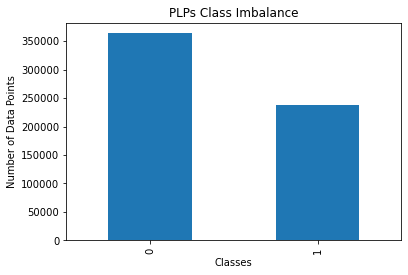

In [25]:
target_count = df_final_plp.Category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='PLPs Class Imbalance');
plt.rcParams["figure.dpi"]=300
plt.xlabel("Classes")
plt.ylabel("Number of Data Points")

In [26]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_plp_train_resampled, y_plp_train_resampled = rus.fit_resample(X_plp_train, y_plp_train)
print(X_plp_train_resampled.shape, y_plp_train_resampled.shape)
print(type(X_plp_train_resampled), type(y_plp_train_resampled))

(429626, 13) (429626,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [27]:
df_final_plp_resampled = X_plp_train_resampled.copy()
df_final_plp_resampled['Category'] = y_plp_train_resampled

Class 0: 214813
Class 1: 214813
Proportion: 1.0 : 1


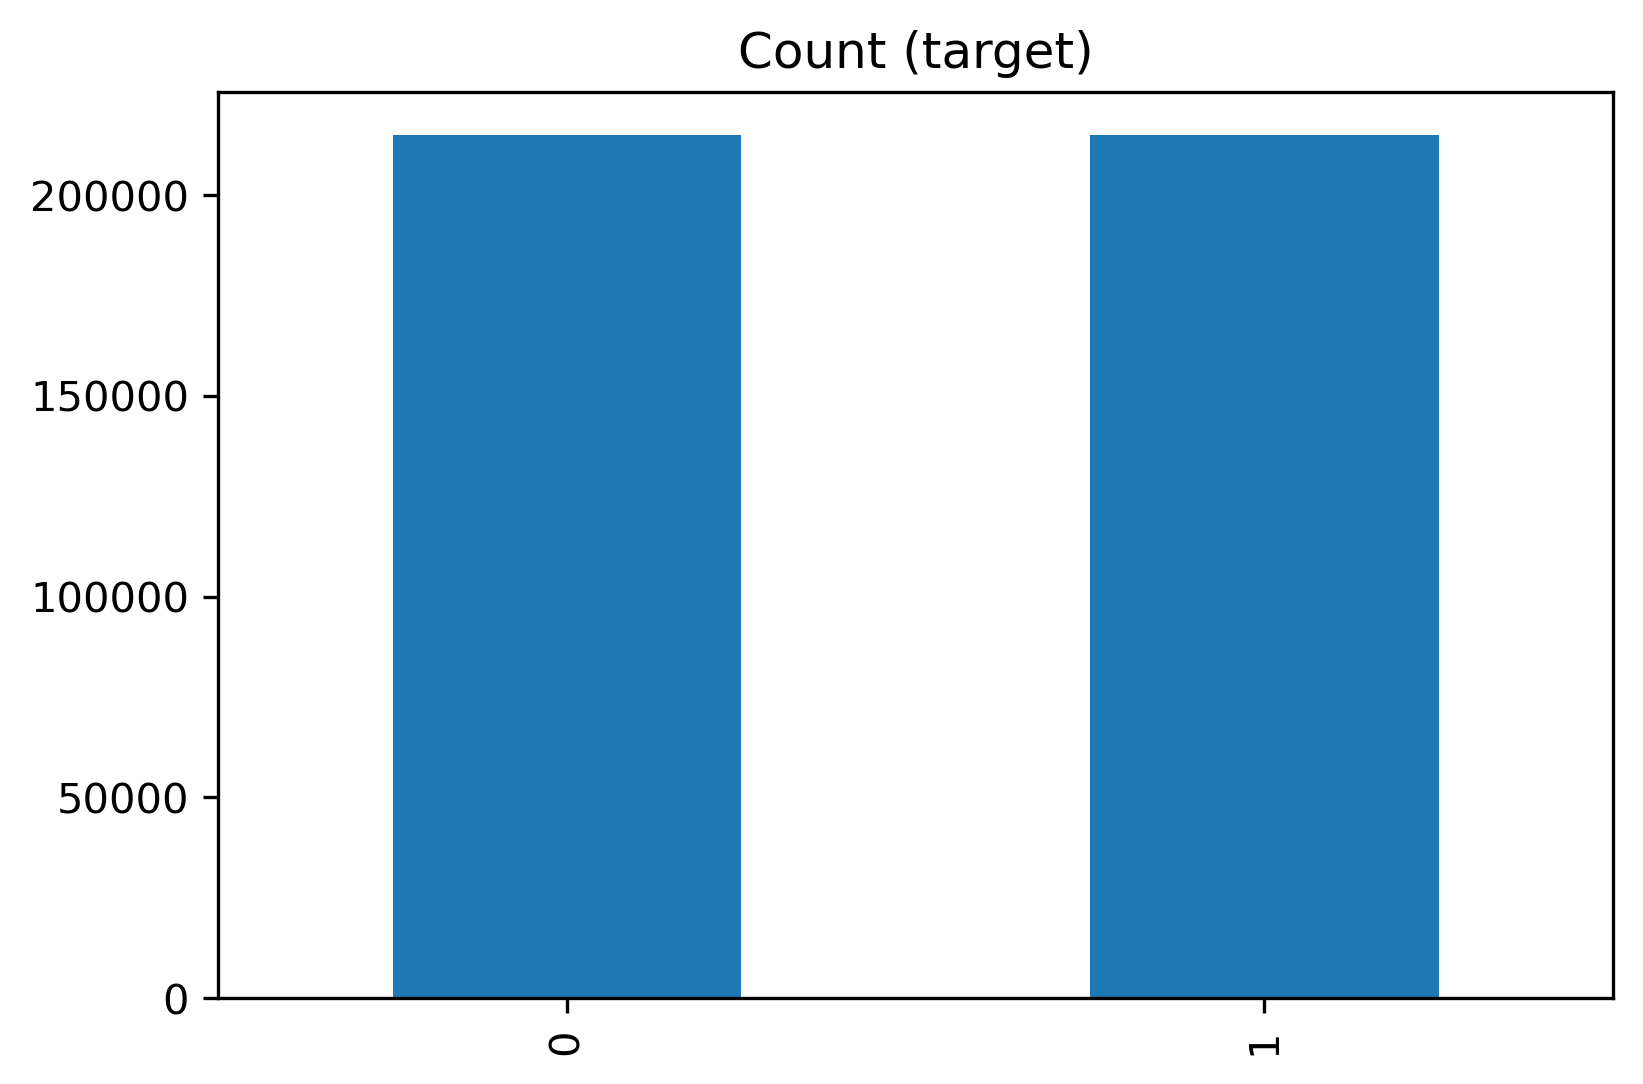

In [28]:
target_count = df_final_plp_resampled.Category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [31]:
X_plp_train_resampled = np.array(X_plp_train_resampled)
y_plp_train_resampled = np.array(y_plp_train_resampled)
X_plp_test = np.array(X_plp_test)
y_plp_test = np.array(y_plp_test)

In [32]:
print(X_plp_train_resampled.max(), X_plp_test.max())

13.688583715259533 13.112462593738554


In [33]:
X_plp_train_scaled = normalizeData(X_plp_train_resampled)
X_plp_test_scaled = normalizeData(X_plp_test)

In [35]:
print(X_plp_train_scaled.max(), X_plp_test_scaled.max())

1.0000000000000002 1.0000000000000002


In [36]:
# expanding the dimensions for conv 1d model
X_plp_train_conv1D = np.expand_dims(X_plp_train_scaled, axis=2)
X_plp_test_conv1D = np.expand_dims(X_plp_test_scaled, axis=2)

##### PLP - Training Conv 1D

In [38]:
import keras_metrics
dense_layer = 1
layer_size = 128
conv_layer = 3

NAME = "PLPs - Conv1D Model - {}".format(int(time.time()))
print(NAME)
tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
model = Sequential()
model.add(Conv1D(layer_size, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=X_plp_train_conv1D.shape[1:]))
model.add(MaxPool1D())

for l in range(conv_layer-1):
    model.add(Conv1D(layer_size, 3, padding="same", activation="relu"))
    model.add(MaxPool1D())

model.add(Dropout(0.4))

model.add(Flatten())

for d in range(dense_layer):
    model.add(Dense(layer_size,activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)

# opt = SGD(lr=0.01)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

PLPs - Conv1D Model - 1623180370
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)      

In [39]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
for train_index, val_index in skf.split(np.zeros(len(X_plp_train_scaled)),y_plp_train_resampled):
    print("****Modelling Starts*****")

    X_plp_train_cv = X_plp_train_scaled[train_index]
    X_plp_test_cv = X_plp_train_scaled[val_index]
    
    y_plp_train_cv = y_plp_train_resampled[train_index]
    y_plp_test_cv = y_plp_train_resampled[val_index]
    

    #transforming the data - 
    
#     rus = RandomUnderSampler(random_state=0)
#     X_plp_train_resampled, y_plp_train_resampled = rus.fit_resample(X_plp_train_cv, y_plp_train_cv)
# #     print(X_train_resampled.shape, y_train_resampled.shape)
# #     print(type(X_train_resampled), type(y_train_resampled))
    
#     X_train_scaled = normalizeData(X_plp_train_resampled)
#     X_test_scaled = normalizeData(X_plp_test_cv)
#     X_scaled = normalizeData(X_plp_cv)
    
    X_train_conv1D = np.expand_dims(X_plp_train_cv, axis=2)
    X_test_conv1D = np.expand_dims(X_plp_test_cv, axis=2)
    
#     print(X_train_conv1D.shape, X_test_conv1D.shape, y_plp_train_resampled.shape, y_plp_test_cv.shape)
    
    #model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))
    hist = model.fit(X_train_conv1D, y_plp_train_cv, batch_size=32, epochs=20, validation_data=(X_test_conv1D, y_plp_test_cv), callbacks=[tensorboard])
#     break
    
    fold += 1

****Modelling Starts*****
Epoch 1/20
10741/10741 [==============================] - 59s 4ms/step - loss: 0.6915 - accuracy: 0.5275 - precision: 0.5069 - recall: 0.4897 - val_loss: 0.6544 - val_accuracy: 0.6139 - val_precision: 0.1966 - val_recall: 0.3318
Epoch 2/20
10741/10741 [==============================] - 43s 4ms/step - loss: 0.6389 - accuracy: 0.6281 - precision: 0.6211 - recall: 0.6092 - val_loss: 0.5964 - val_accuracy: 0.6696 - val_precision: 0.2229 - val_recall: 0.3473
Epoch 3/20
10741/10741 [==============================] - 43s 4ms/step - loss: 0.5997 - accuracy: 0.6712 - precision: 0.6866 - recall: 0.6196 - val_loss: 0.5720 - val_accuracy: 0.6941 - val_precision: 0.2746 - val_recall: 0.2841
Epoch 4/20
10741/10741 [==============================] - 42s 4ms/step - loss: 0.5781 - accuracy: 0.6894 - precision: 0.7121 - recall: 0.6367 - val_loss: 0.5775 - val_accuracy: 0.6900 - val_precision: 0.2214 - val_recall: 0.3949
Epoch 5/20
10741/10741 [==============================] - 

Epoch 8/20
10741/10741 [==============================] - 42s 4ms/step - loss: 0.5082 - accuracy: 0.7386 - precision: 0.7607 - recall: 0.6995 - val_loss: 0.5009 - val_accuracy: 0.7433 - val_precision: 0.2724 - val_recall: 0.3598
Epoch 9/20
10741/10741 [==============================] - 42s 4ms/step - loss: 0.5077 - accuracy: 0.7392 - precision: 0.7584 - recall: 0.7033 - val_loss: 0.5014 - val_accuracy: 0.7431 - val_precision: 0.2680 - val_recall: 0.3666
Epoch 10/20
10741/10741 [==============================] - 42s 4ms/step - loss: 0.5073 - accuracy: 0.7396 - precision: 0.7594 - recall: 0.7014 - val_loss: 0.5006 - val_accuracy: 0.7438 - val_precision: 0.2834 - val_recall: 0.3445
Epoch 11/20
10741/10741 [==============================] - 43s 4ms/step - loss: 0.5075 - accuracy: 0.7386 - precision: 0.7590 - recall: 0.6987 - val_loss: 0.5000 - val_accuracy: 0.7439 - val_precision: 0.2798 - val_recall: 0.3502
Epoch 12/20
10741/10741 [==============================] - 42s 4ms/step - loss: 0.

Epoch 19/20
10741/10741 [==============================] - 41s 4ms/step - loss: 0.5044 - accuracy: 0.7416 - precision: 0.7620 - recall: 0.7038 - val_loss: 0.4972 - val_accuracy: 0.7464 - val_precision: 0.2787 - val_recall: 0.3513
Epoch 20/20
10741/10741 [==============================] - 41s 4ms/step - loss: 0.5042 - accuracy: 0.7415 - precision: 0.7598 - recall: 0.7043 - val_loss: 0.4972 - val_accuracy: 0.7464 - val_precision: 0.2787 - val_recall: 0.3513


In [40]:
val_acc_mean = np.mean(hist.history['val_accuracy'])
val_precision_mean = np.mean(hist.history['val_precision'])
val_recall_mean = np.mean(hist.history['val_recall'])
print(val_acc_mean, val_precision_mean, val_recall_mean)

0.7463887214660645 0.2787290170788765 0.3512881055474281


##### PLP - Testing Conv 1D

In [41]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the Conv1D model
y_pred_prob = model.predict(X_plp_test_conv1D)
y_pred_classes = model.predict_classes(X_plp_test_conv1D)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:00:03.244660


In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_plp_test, y_pred_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_plp_test, y_pred_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_plp_test, y_pred_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_plp_test, y_pred_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_plp_test, y_pred_classes)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_plp_test, y_pred_prob)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_plp_test, y_pred_classes)
print(matrix)

Accuracy: 0.559724
Precision: 0.470830
Recall: 0.919583
F1 score: 0.622789
Cohens kappa: 0.209527
ROC AUC: 0.768514
[[11819 24599]
 [ 1914 21887]]


##### PLP - Training  and Testing SVM Linear

In [45]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 70000,
        1: 70000
    })
X_plp_resampled, y_plp_resampled = rus.fit_resample(X_plp_train_scaled, y_plp_train_resampled)
print(X_plp_resampled.shape, y_plp_resampled.shape)
print(type(X_plp_resampled), type(y_plp_resampled))

(140000, 13) (140000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [46]:
## fitting the svm linear model
start_time = datetime.datetime.now()

svc=SVC(kernel='linear')

svc.fit(X_plp_resampled, y_plp_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:08:49.888406


In [47]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = svc.predict(X_plp_test_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:02:21.674879


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_plp_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_plp_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_plp_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_plp_test, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_plp_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_plp_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_plp_test, y_pred)
print(matrix)

Accuracy: 0.506701
Precision: 0.440396
Recall: 0.916558
F1 score: 0.594933
Cohens kappa: 0.130883
ROC AUC: 0.577698
[[ 8698 27720]
 [ 1986 21815]]


In [56]:
# X_plp_scaled = normalizeData(X_plp_resampled)

In [57]:
# msg = "SVM - 5 fold cross validation Linear Training Model (PLP)"
# start_time = startTime(msg)

# svc=SVC(kernel='linear')
# scoring = ["accuracy", "precision", "recall"]
# # scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
# scores = cross_validate(svc, X_plp_scaled, y_plp_resampled, scoring=scoring, cv=5, return_train_score=True)
# print(scores)

# # end time
# end_time = endTime(msg)

# #total time
# totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 Start Time  2021-05-30 12:01:36.508300
{'fit_time': array([109.64545631, 109.38254786, 109.24196362, 110.41520596,
       109.94017982]), 'score_time': array([17.57213473, 17.58157682, 17.51831245, 17.59816623, 17.4789803 ]), 'test_accuracy': array([0.6654375, 0.6683125, 0.667875 , 0.6718125, 0.6645625]), 'train_accuracy': array([0.6685625 , 0.66803125, 0.66796875, 0.6664375 , 0.66742188]), 'test_precision': array([0.67444313, 0.67430421, 0.67620047, 0.67988483, 0.6735205 ]), 'train_precision': array([0.67678291, 0.67656137, 0.67647252, 0.67462295, 0.67443753]), 'test_recall': array([0.639625, 0.651125, 0.64425 , 0.649375, 0.63875 ]), 'train_recall': array([0.6453125, 0.643875 , 0.643875 , 0.643    , 0.6473125])}
 ====End=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 End Time  2021-05-30 12:18:03.190132
SVM - 5 fold cross validation Linear Training Model (GFCCS) =====Total Time===== 0

In [58]:
# mean_test_accuracy = np.mean(scores['test_accuracy'])
# mean_test_precision = np.mean(scores['test_precision'])
# mean_test_recall = np.mean(scores['test_recall'])
# print("mean_test_accuracy ", mean_test_accuracy)
# print("mean_test_precision ", mean_test_precision)
# print("mean_test_recall ", mean_test_recall)

mean_test_accuracy  0.6676
mean_test_precision  0.6756706266499974
mean_test_recall  0.644625


##### PLP - Training and Testing SVM RBF

In [50]:
## fitting the svm linear model
start_time = datetime.datetime.now()

svc=SVC(kernel='rbf')

svc.fit(X_plp_resampled, y_plp_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:12:04.238389


In [51]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = svc.predict(X_plp_test_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:04:34.404413


In [52]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_plp_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_plp_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_plp_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_plp_test, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_plp_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_plp_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_plp_test, y_pred)
print(matrix)

Accuracy: 0.559325
Precision: 0.470431
Recall: 0.914415
F1 score: 0.621252
Cohens kappa: 0.207713
ROC AUC: 0.620836
[[11918 24500]
 [ 2037 21764]]


In [59]:
# msg = "SVM - 5 fold cross validation Linear Training Model (PLP)"
# start_time = startTime(msg)

# svc=SVC(kernel='rbf')
# scoring = ["accuracy", "precision", "recall"]
# # scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
# scores = cross_validate(svc, X_plp_scaled, y_plp_resampled, scoring=scoring, cv=5, return_train_score=True)
# print(scores)

# # end time
# end_time = endTime(msg)

# #total time
# totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 Start Time  2021-05-30 12:18:03.203079
{'fit_time': array([158.01833034, 155.81704664, 155.76283073, 155.72850585,
       153.32171774]), 'score_time': array([35.51917195, 35.45709944, 35.69684839, 35.6349349 , 35.60058832]), 'test_accuracy': array([0.7569375, 0.75275  , 0.75825  , 0.7580625, 0.7528125]), 'train_accuracy': array([0.76435937, 0.76534375, 0.76398438, 0.76434375, 0.76432813]), 'test_precision': array([0.78624147, 0.77736626, 0.78968031, 0.78693537, 0.78109798]), 'train_precision': array([0.7929697 , 0.79194746, 0.79622681, 0.79463602, 0.79378973]), 'test_recall': array([0.70575 , 0.708375, 0.704   , 0.70775 , 0.7025  ]), 'train_recall': array([0.71553125, 0.71978125, 0.7095625 , 0.7129375 , 0.7141875 ])}
 ====End=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 End Time  2021-05-30 12:45:52.019012
SVM - 5 fold cross validation Linear Training Model (GFCCS) =====Total Time==

In [60]:
# mean_test_accuracy = np.mean(scores['test_accuracy'])
# mean_test_precision = np.mean(scores['test_precision'])
# mean_test_recall = np.mean(scores['test_recall'])
# print("mean_test_accuracy ", mean_test_accuracy)
# print("mean_test_precision ", mean_test_precision)
# print("mean_test_recall ", mean_test_recall)

mean_test_accuracy  0.7557625
mean_test_precision  0.7842642792532551
mean_test_recall  0.705675


##### PLP - Training Extra Tree Classifier

In [53]:
seed = 7
kfold = KFold(n_splits = 5, random_state = seed, shuffle = True)

In [54]:
num_trees = 200
max_features = 12

In [55]:
model = ExtraTreesClassifier(n_estimators = num_trees, max_features = max_features)

In [57]:
msg = "Extra Tree Classifier"
start_time = startTime(msg)
scoring = ["accuracy", "precision", "recall"]
# results = cross_val_score(model, X_scaled, y, cv = kfold, scoring=scoring)
results = cross_validate(model, X_plp_train_scaled, y_plp_train_resampled, scoring=scoring, cv=kfold, return_train_score=True)

# print(results.mean())

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  Extra Tree Classifier
 Start Time  2021-06-08 21:18:17.873613
 ====End=======  Extra Tree Classifier
 End Time  2021-06-08 21:34:18.323437
Extra Tree Classifier =====Total Time===== 0:16:00.449824


In [59]:
mean_test_accuracy = np.mean(results['test_accuracy'])
mean_test_precision = np.mean(results['test_precision'])
mean_test_recall = np.mean(results['test_recall'])

In [60]:
print(mean_test_accuracy)
print(mean_test_precision)
print(mean_test_recall)

0.8028494577524541
0.8175502358080342
0.7797198570208345


##### PLP - Testing Extra Tree Classifier

In [62]:
## fitting the extra tree classifier  model
start_time = datetime.datetime.now()

model.fit(X_plp_train_scaled, y_plp_train_resampled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:03:41.036141


In [63]:
## Validating against the validation dataset

start_time = datetime.datetime.now()
#testing the SVM model
y_pred = model.predict(X_plp_test_scaled)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print(total_time)

0:00:04.190754


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_plp_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_plp_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_plp_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_plp_test, y_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_plp_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_plp_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_plp_test, y_pred)
print(matrix)

Accuracy: 0.625716
Precision: 0.515241
Recall: 0.896265
F1 score: 0.654326
Cohens kappa: 0.305969
ROC AUC: 0.672582
[[16348 20070]
 [ 2469 21332]]


##### RPLP - Splitting, Balancing and Normalizing

In [77]:
# Splitting the data in X and Y
X_rplp = df_final_rplp.drop('Category', axis=1)
y_rplp = df_final_rplp['Category']

In [78]:
X_rplp_train, X_rplp_test, y_rplp_train, y_rplp_test = train_test_split(X_rplp, y_rplp, test_size = 0.30)

In [79]:
print(X_rplp_train.shape, X_rplp_test.shape, y_rplp_train.shape, y_rplp_test.shape)

(421528, 13) (180655, 13) (421528,) (180655,)


Class 0: 363569
Class 1: 238614
Proportion: 1.52 : 1


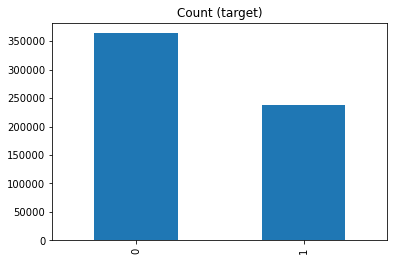

In [80]:
target_count = df_final_rplp.Category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [75]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_rplp_resampled, y_rplp_resampled = rus.fit_resample(X_rplp, y_rplp)
print(X_rplp_resampled.shape, y_rplp_resampled.shape)
print(type(X_rplp_resampled), type(y_rplp_resampled))

(80000, 13) (80000,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [76]:
X_rplp_scaled = normalizeData(X_rplp_resampled)

In [77]:
msg = "SVM - 5 fold cross validation Linear Training Model (GFCCS)"
start_time = startTime(msg)

svc=SVC(kernel='linear')
scoring = ["accuracy", "precision", "recall"]
# scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
scores = cross_validate(svc, X_rplp_scaled, y_rplp_resampled, scoring=scoring, cv=5, return_train_score=True)
print(scores)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 Start Time  2021-05-30 13:23:53.320487
{'fit_time': array([123.87475443, 122.95491529, 123.24133015, 123.47197342,
       122.81147885]), 'score_time': array([23.17909861, 22.96977186, 22.90721154, 23.00268936, 22.93012285]), 'test_accuracy': array([0.515625 , 0.5208125, 0.5175   , 0.523    , 0.5169375]), 'train_accuracy': array([0.51684375, 0.52103125, 0.522875  , 0.52101562, 0.523     ]), 'test_precision': array([0.51375743, 0.52038692, 0.51674241, 0.52143523, 0.5160526 ]), 'train_precision': array([0.51488704, 0.52040507, 0.5223375 , 0.51947977, 0.52164069]), 'test_recall': array([0.5835  , 0.53125 , 0.540125, 0.5595  , 0.5445  ]), 'train_recall': array([0.5825625 , 0.536375  , 0.53490625, 0.5604375 , 0.55440625])}
 ====End=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 End Time  2021-05-30 13:43:45.362620
SVM - 5 fold cross validation Linear Training Model (GFCCS) =====Total Time==

In [78]:
mean_test_accuracy = np.mean(scores['test_accuracy'])
mean_test_precision = np.mean(scores['test_precision'])
mean_test_recall = np.mean(scores['test_recall'])
print("mean_test_accuracy ", mean_test_accuracy)
print("mean_test_precision ", mean_test_precision)
print("mean_test_recall ", mean_test_recall)

mean_test_accuracy  0.518775
mean_test_precision  0.517674917370383
mean_test_recall  0.5517749999999999


In [ ]:
msg = "SVM - 5 fold cross validation Linear Training Model (GFCCS)"
start_time = startTime(msg)

svc=SVC(kernel='rbf')
scoring = ["accuracy", "precision", "recall"]
# scores = cross_val_score(svc, X_scaled, y, cv=10, scoring=scoring) #cv is cross validation
scores = cross_validate(svc, X_rplp_scaled, y_rplp_resampled, scoring=scoring, cv=5, return_train_score=True)
print(scores)

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  SVM - 5 fold cross validation Linear Training Model (GFCCS)
 Start Time  2021-05-30 13:43:45.377187


In [ ]:
mean_test_accuracy = np.mean(scores['test_accuracy'])
mean_test_precision = np.mean(scores['test_precision'])
mean_test_recall = np.mean(scores['test_recall'])
print("mean_test_accuracy ", mean_test_accuracy)
print("mean_test_precision ", mean_test_precision)
print("mean_test_recall ", mean_test_recall)

In [81]:
seed = 7
kfold = KFold(n_splits = 5, random_state = seed, shuffle = True)

In [82]:
num_trees = 200
max_features = 12

In [83]:
model = ExtraTreesClassifier(n_estimators = num_trees, max_features = max_features)

In [84]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy={
        0: 40000,
        1: 40000
    })
X_rplp_resampled, y_rplp_resampled = rus.fit_resample(X_rplp, y_rplp)
print(X_rplp_resampled.shape, y_rplp_resampled.shape)
print(type(X_rplp_resampled), type(y_rplp_resampled))

(80000, 13) (80000,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [85]:
scaler = MinMaxScaler()
scaler.fit(X_rplp_resampled)
X_scaled = scaler.transform(X_rplp_resampled)

In [86]:
msg = "Extra Tree Classifier"
start_time = startTime(msg)
scoring = ["accuracy", "precision", "recall"]
# results = cross_val_score(model, X_scaled, y, cv = kfold, scoring=scoring)
results = cross_validate(model, X_scaled, y_rplp_resampled, scoring=scoring, cv=kfold, return_train_score=True)

# print(results.mean())

# end time
end_time = endTime(msg)

#total time
totalTime(msg, start_time, end_time)

 ====Start=======  Extra Tree Classifier
 Start Time  2021-05-30 14:26:41.742282
 ====End=======  Extra Tree Classifier
 End Time  2021-05-30 14:29:38.301989
Extra Tree Classifier =====Total Time===== 0:02:56.559707


In [87]:
print(results)

{'fit_time': array([30.51661325, 30.87605786, 30.82632637, 30.58109164, 30.45466542]), 'score_time': array([1.03168726, 1.02943397, 1.02597332, 1.02933025, 1.0397408 ]), 'test_accuracy': array([0.686125 , 0.694625 , 0.6886875, 0.6928125, 0.68425  ]), 'train_accuracy': array([0.999875  , 0.99979688, 0.9998125 , 0.99979688, 0.99984375]), 'test_precision': array([0.68126815, 0.68749242, 0.6844167 , 0.68694704, 0.67797426]), 'train_precision': array([0.99974992, 0.99959421, 0.99962521, 0.99959391, 0.99968749]), 'test_recall': array([0.70217012, 0.71041745, 0.69939955, 0.7085    , 0.70353264]), 'train_recall': array([1., 1., 1., 1., 1.])}


In [88]:
mean_test_accuracy = np.mean(results['test_accuracy'])
mean_test_precision = np.mean(results['test_precision'])
mean_test_recall = np.mean(results['test_recall'])

In [89]:
print(mean_test_accuracy)
print(mean_test_precision)
print(mean_test_recall)

0.6893
0.6836197120012069
0.7048039519368208


In [94]:
import keras_metrics
dense_layer = 1
layer_size = 128
conv_layer = 3

model = Sequential()
model.add(Conv1D(layer_size, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=(13, 1)))
model.add(MaxPool1D())

for l in range(conv_layer-1):
    model.add(Conv1D(layer_size, 3, padding="same", activation="relu"))
    model.add(MaxPool1D())

model.add(Dropout(0.4))

model.add(Flatten())

for d in range(dense_layer):
    model.add(Dense(layer_size,activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()

opt = SGD(lr=0.01)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)           

In [95]:
X_rplp_cv = X_rplp.copy()
y_rplp_cv = y_rplp.copy()
print(X_rplp_cv.shape, y_rplp_cv.shape)

X_rplp_cv = np.array(X_rplp_cv)
y_rplp_cv = np.array(y_rplp_cv)
print(type(X_rplp_cv), type(y_rplp_cv))

(602183, 13) (602183,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [96]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
for train_index, val_index in skf.split(np.zeros(len(X_rplp_cv)),y_rplp_cv):
    print("****Modelling Starts*****")

    X_rplp_train_cv = X_rplp_cv[train_index]
    X_rplp_test_cv = X_rplp_cv[val_index]
    
    y_rplp_train_cv = y_rplp_cv[train_index]
    y_rplp_test_cv = y_rplp_cv[val_index]
    

    #transforming the data - 
    
    rus = RandomUnderSampler(random_state=0)
    X_rplp_train_resampled, y_rplp_train_resampled = rus.fit_resample(X_rplp_train_cv, y_rplp_train_cv)
#     print(X_train_resampled.shape, y_train_resampled.shape)
#     print(type(X_train_resampled), type(y_train_resampled))
    
    X_train_scaled = normalizeData(X_rplp_train_resampled)
    X_test_scaled = normalizeData(X_rplp_test_cv)
    X_scaled = normalizeData(X_rplp_cv)
    
    X_train_conv1D = np.expand_dims(X_train_scaled, axis=2)
    X_test_conv1D = np.expand_dims(X_test_scaled, axis=2)
    
#     print(X_train_conv1D.shape, X_test_conv1D.shape, y_plp_train_resampled.shape, y_plp_test_cv.shape)
    
    #model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))
    hist = model.fit(X_train_conv1D, y_rplp_train_resampled, batch_size=32, epochs=20, validation_data=(X_test_conv1D, y_rplp_test_cv))
#     break
    
    fold += 1

****Modelling Starts*****
Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


11931/11931 [==============================] - 62s 4ms/step - loss: 0.6930 - accuracy: 0.5083 - precision: 0.5068 - recall: 0.5642 - val_loss: 0.6920 - val_accuracy: 0.5252 - val_precision: 0.2017 - val_recall: 0.4269
Epoch 2/20
11931/11931 [==============================] - 48s 4ms/step - loss: 0.6911 - accuracy: 0.5330 - precision: 0.5277 - recall: 0.5830 - val_loss: 0.6919 - val_accuracy: 0.5017 - val_precision: 0.1984 - val_recall: 0.4965
Epoch 3/20
11931/11931 [==============================] - 48s 4ms/step - loss: 0.6846 - accuracy: 0.5525 - precision: 0.5410 - recall: 0.6060 - val_loss: 0.6565 - val_accuracy: 0.6166 - val_precision: 0.2552 - val_recall: 0.1141
Epoch 4/20
11931/11931 [==============================] - 48s 4ms/step - loss: 0.6769 - accuracy: 0.5713 - precision: 0.5591 - recall: 0.6490 - val_loss: 0.6746 - val_accuracy: 0.5621 - val_precision: 0.2169 - val_recall: 0.4440
Epoch 5/20
11931/11931 [==============================] - 47s 4ms/step - loss: 0.6690 - accurac

Epoch 11/20
11931/11931 [==============================] - 46s 4ms/step - loss: 0.6083 - accuracy: 0.6588 - precision: 0.6511 - recall: 0.6869 - val_loss: 0.6494 - val_accuracy: 0.6255 - val_precision: 0.2487 - val_recall: 0.4036
Epoch 12/20
11931/11931 [==============================] - 46s 4ms/step - loss: 0.6067 - accuracy: 0.6601 - precision: 0.6525 - recall: 0.6922 - val_loss: 0.7411 - val_accuracy: 0.5818 - val_precision: 0.2279 - val_recall: 0.5017
Epoch 13/20
11931/11931 [==============================] - 46s 4ms/step - loss: 0.6053 - accuracy: 0.6621 - precision: 0.6551 - recall: 0.6875 - val_loss: 0.6834 - val_accuracy: 0.6110 - val_precision: 0.2407 - val_recall: 0.4387
Epoch 14/20
11931/11931 [==============================] - 46s 4ms/step - loss: 0.6047 - accuracy: 0.6625 - precision: 0.6538 - recall: 0.6872 - val_loss: 0.7382 - val_accuracy: 0.5818 - val_precision: 0.2281 - val_recall: 0.5035
Epoch 15/20
11931/11931 [==============================] - 46s 4ms/step - loss: 

In [97]:
val_acc_mean = np.mean(hist.history['val_accuracy'])
val_precision_mean = np.mean(hist.history['val_precision'])
val_recall_mean = np.mean(hist.history['val_recall'])
print(val_acc_mean, val_precision_mean, val_recall_mean)

0.6438473492860795 0.2578481823205948 0.4377807155251503
